# CHURN

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

# Business Understanding​

In [3]:
df = pd.read_csv('churn - dataset a entrenar.csv')
df_pred = pd.read_csv('churn - dataset a predecir.csv')
df_variables = pd.read_csv('churn - diccionario de variables.csv')

In [4]:
df.head()

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.50,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,55.2300,570.50,71.98,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
2,82.2750,1312.25,75.00,0.0,0.0,0.0,0.0,156.75,8.1450,52.000000,...,0.0,U,U,U,U,U,U,Y,458.0,1000006
3,17.1450,0.00,16.99,0.0,0.0,0.0,0.0,0.00,-0.1550,0.000000,...,0.0,N,U,U,U,U,U,Y,852.0,1000007
4,38.0525,682.50,52.49,0.0,0.0,0.0,0.0,147.50,-3.0625,9.000000,...,1.0,S,U,U,U,U,U,Y,231.0,1000008


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               50000 non-null  float64
 1   mou               50000 non-null  float64
 2   totmrc            50000 non-null  float64
 3   ovrmou            50000 non-null  float64
 4   ovrrev            50000 non-null  float64
 5   vceovr            50000 non-null  float64
 6   roam              50000 non-null  float64
 7   change_mou        50000 non-null  float64
 8   change_rev        50000 non-null  float64
 9   drop_vce          50000 non-null  float64
 10  blck_vce          50000 non-null  float64
 11  blck_dat          50000 non-null  float64
 12  unan_vce          50000 non-null  float64
 13  plcd_vce          50000 non-null  float64
 14  recv_vce          50000 non-null  float64
 15  comp_vce          50000 non-null  float64
 16  comp_dat          50000 non-null  float6

## EDA: Analisis Exploratorio

### Distribución de la target

In [6]:
target = 'churn'
df[target].value_counts(normalize=True)

churn
0    0.54902
1    0.45098
Name: proportion, dtype: float64

Text(0, 0.5, 'Frecuencia')

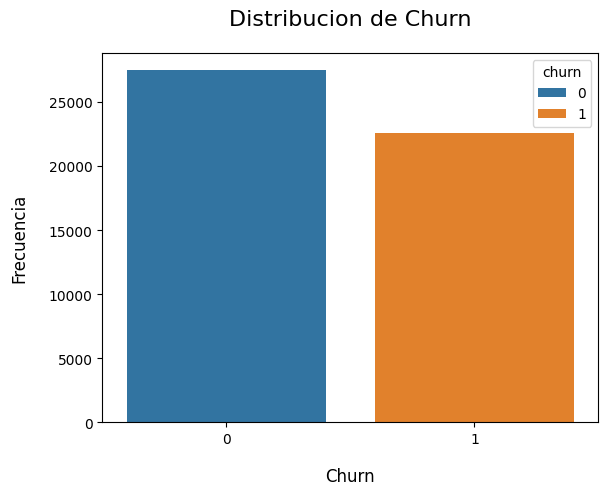

In [7]:
sns.countplot(data=df, 
              x=df[target], 
              hue=df[target])

plt.title('Distribucion de Churn', pad=20, fontsize=16)
plt.xlabel('Churn', labelpad=15, fontsize=12)
plt.ylabel('Frecuencia', labelpad=15, fontsize=12)

### Analisis univariable

In [8]:
# funcion para clasificar nuestras variables por tipos
def obtener_lista_variables(dataset):

    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset.columns:
        if    (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i") and len(dataset[i].unique())!=2 and (i != target):
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i" or dataset[i].dtype.kind=="b" or dataset[i].dtype.kind=="O") and len(dataset[i].unique())==2 and (i != target):
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind=="O") and i != target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [9]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(df)

In [10]:
print('Variables Numericas:', len(lista_numericas))
print('Variables Booleanes:', len(lista_boolean))
print('Variables Categoricas:', len(lista_categoricas))

print('Total:',len(lista_numericas) + len(lista_boolean) + len(lista_categoricas))

Variables Numericas: 65
Variables Booleanes: 12
Variables Categoricas: 8
Total: 85


In [11]:
len(df.columns)

86

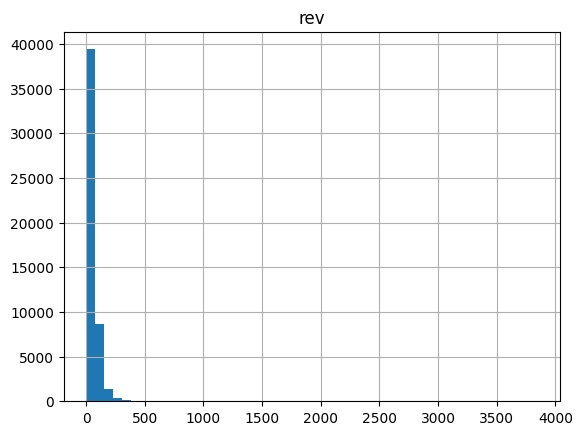

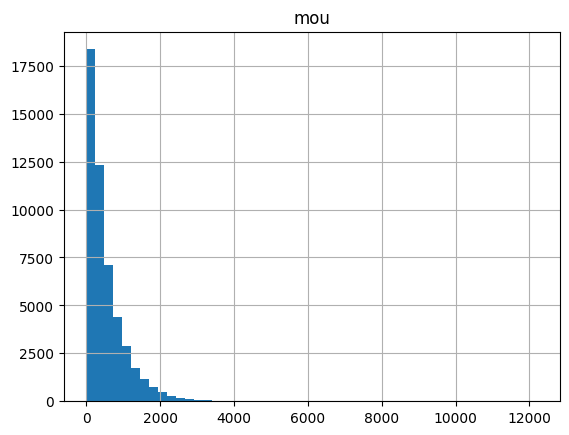

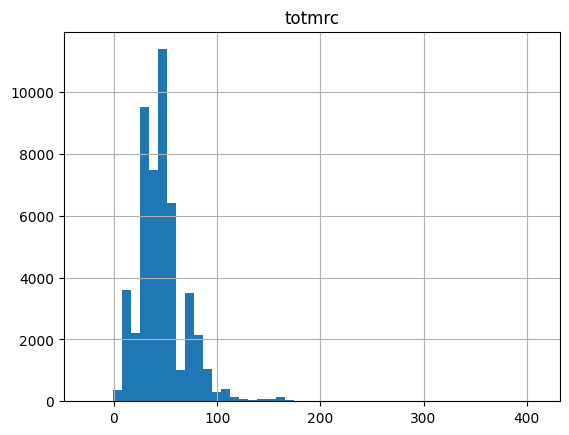

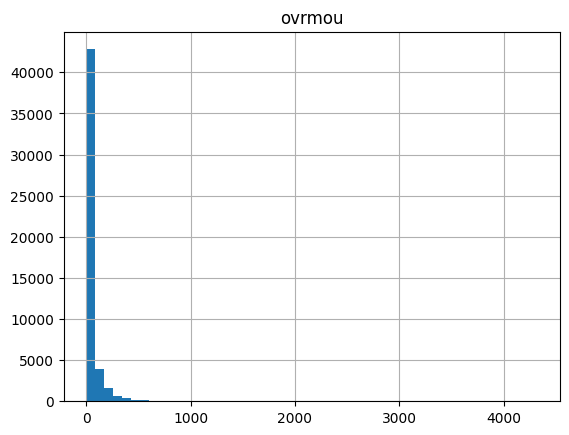

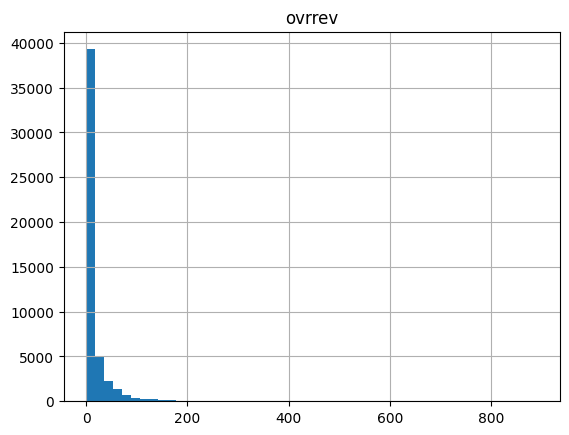

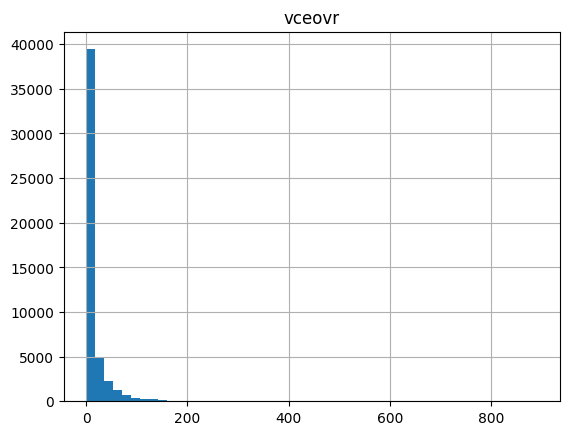

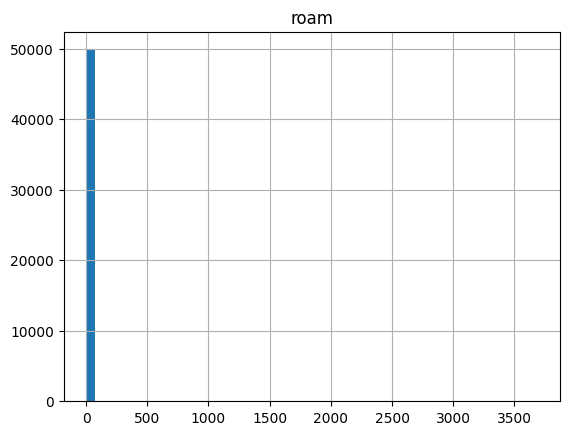

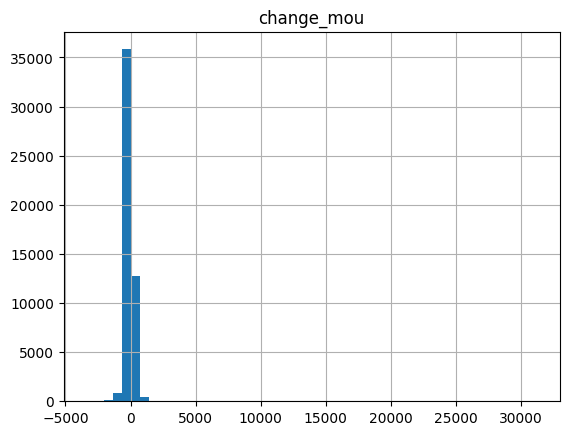

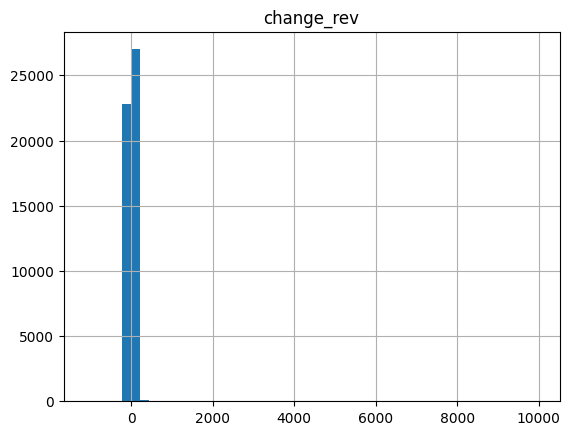

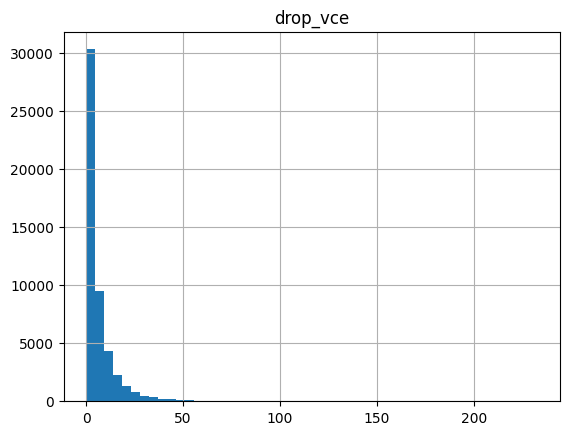

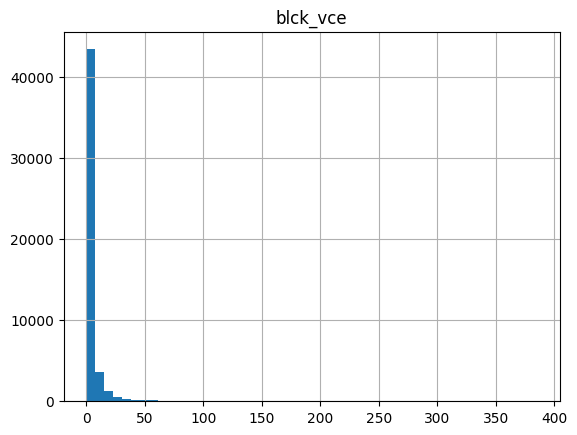

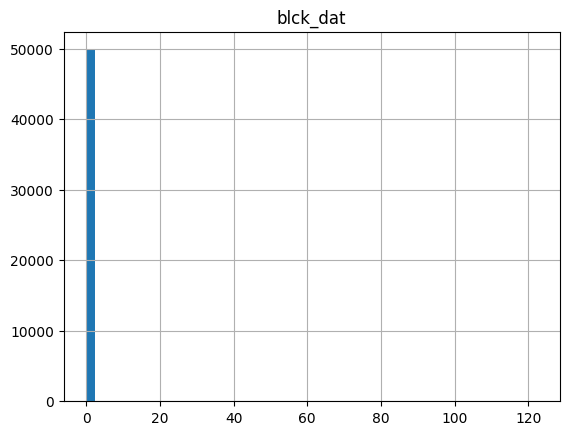

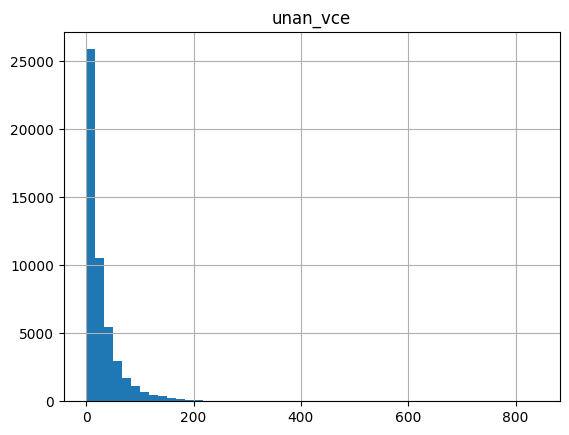

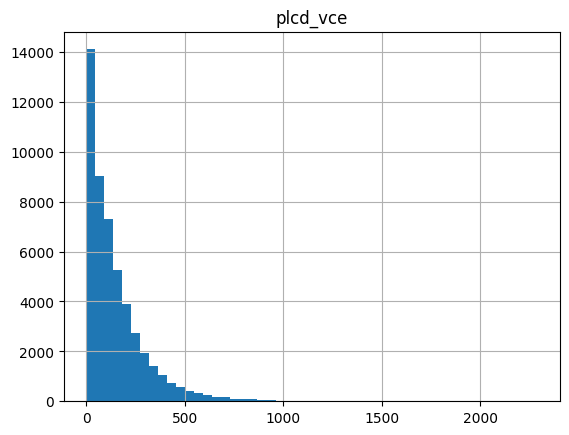

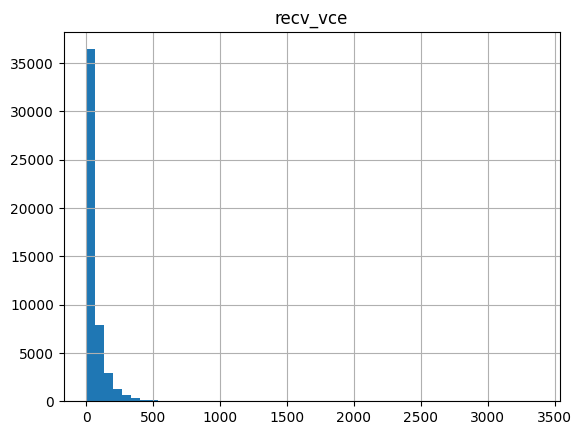

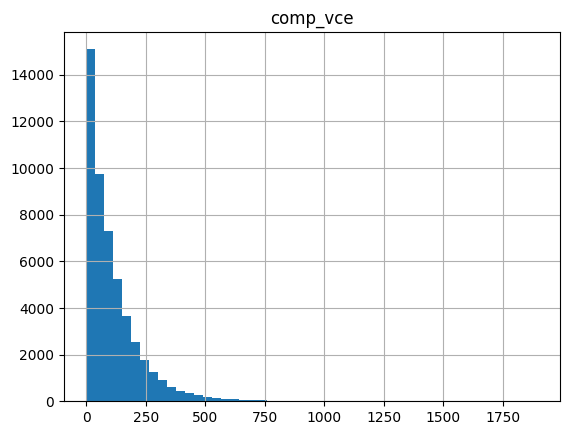

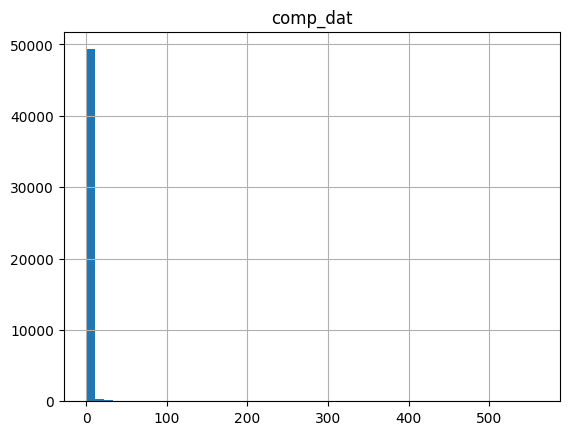

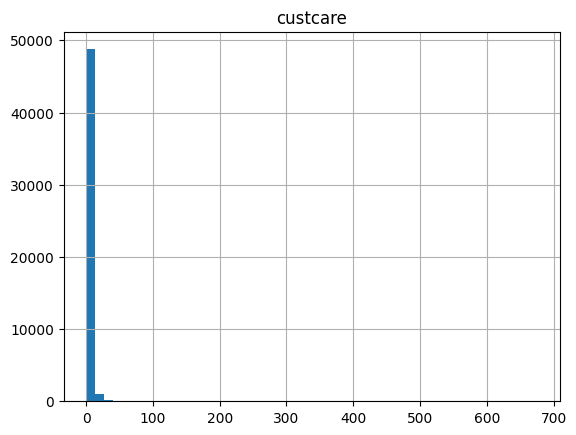

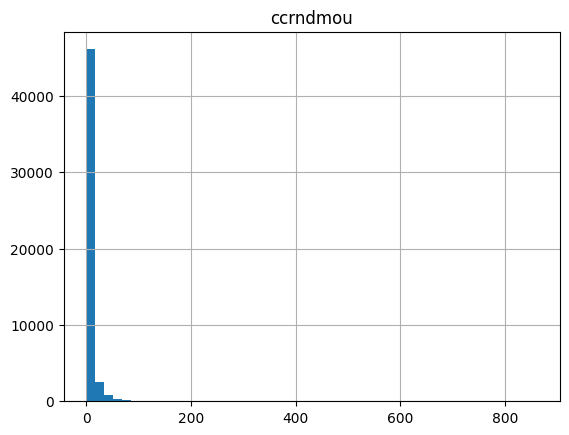

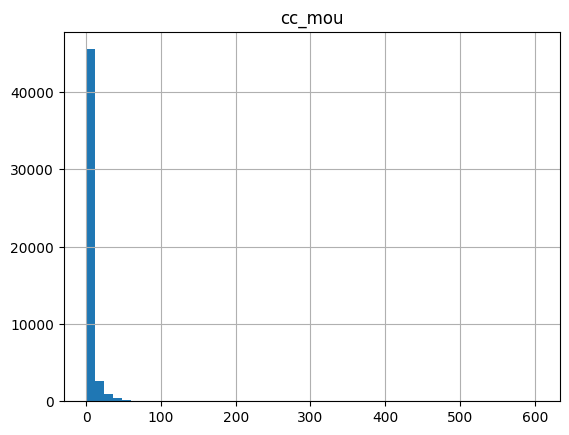

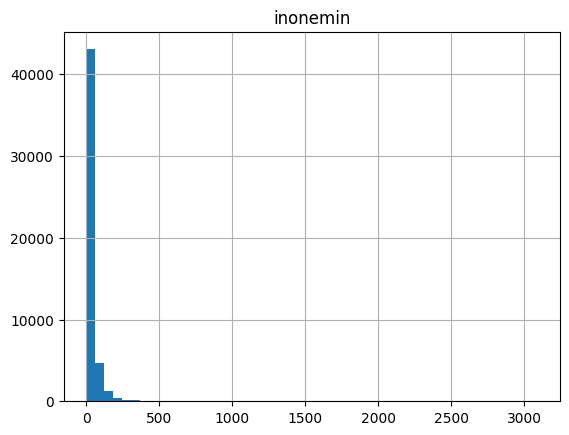

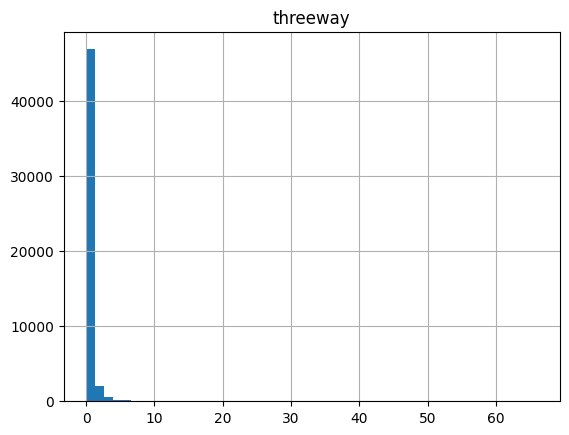

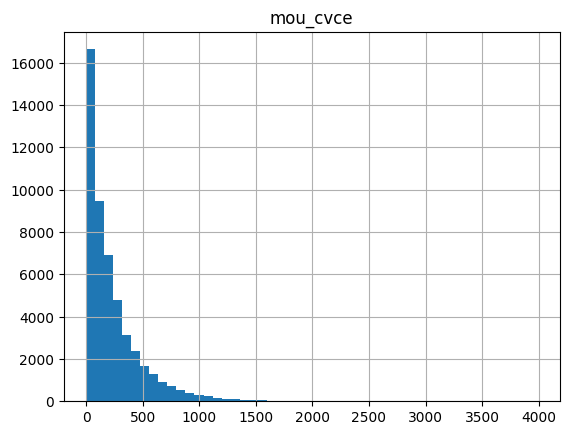

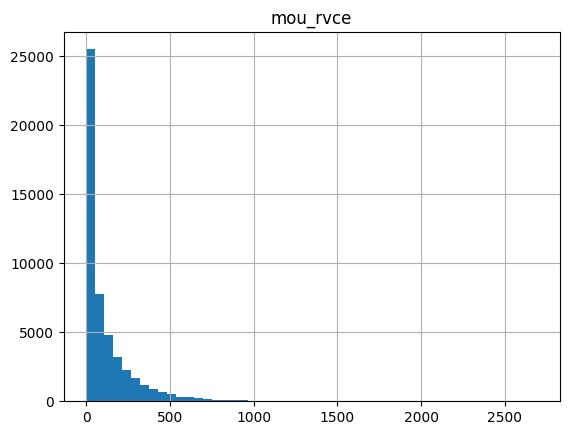

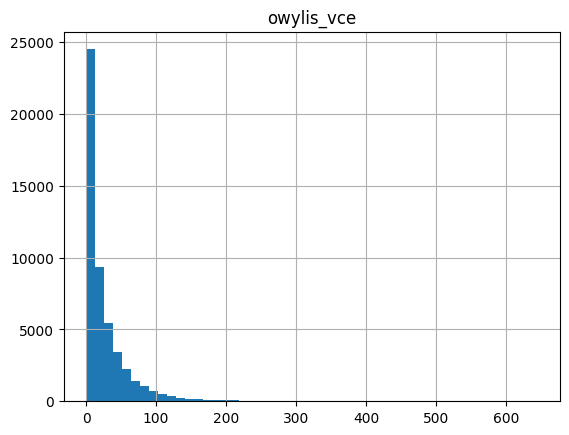

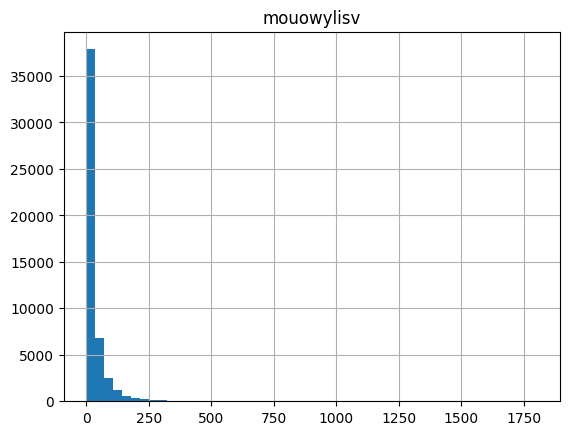

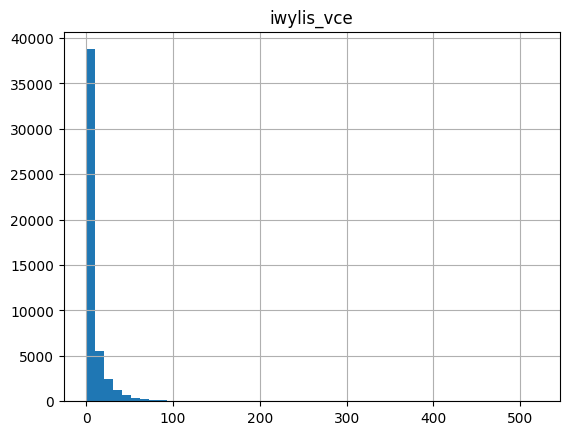

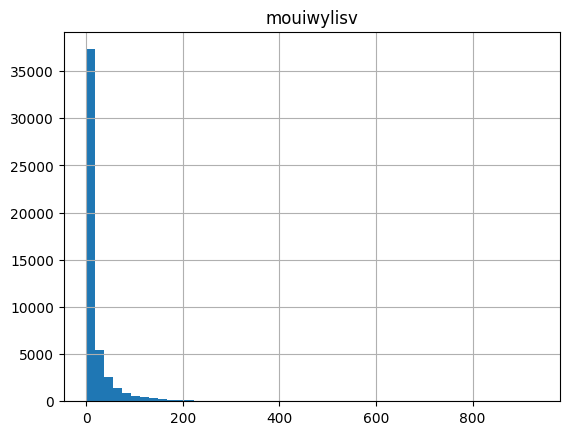

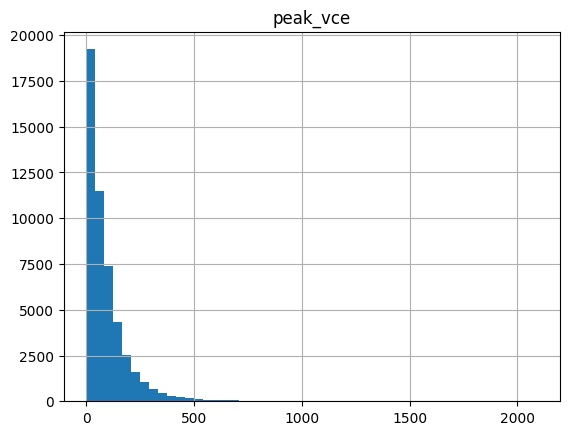

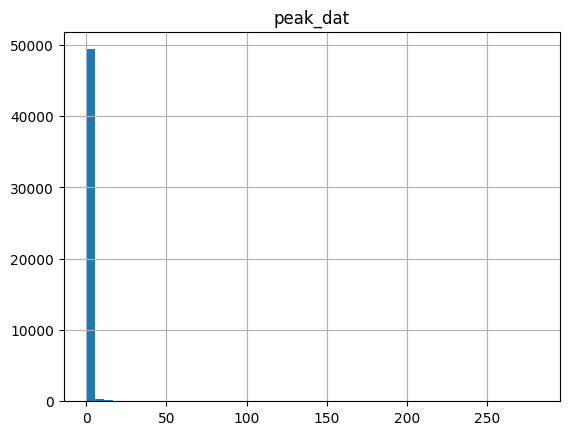

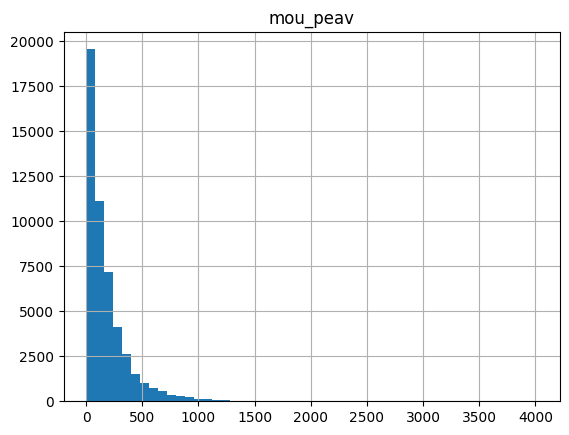

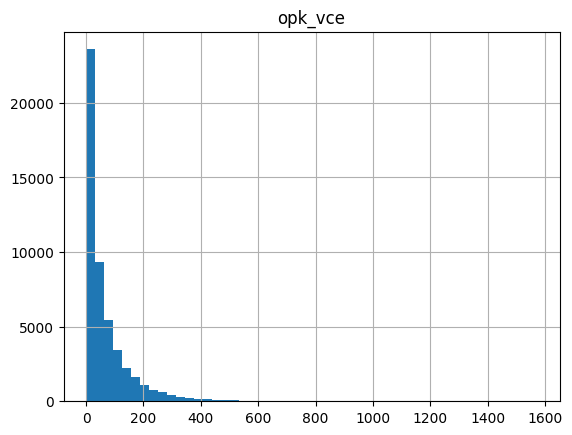

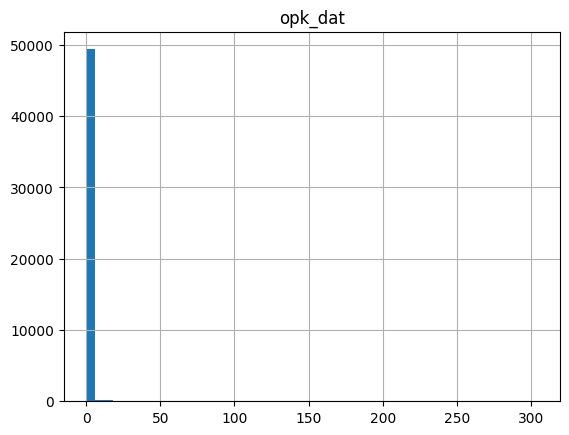

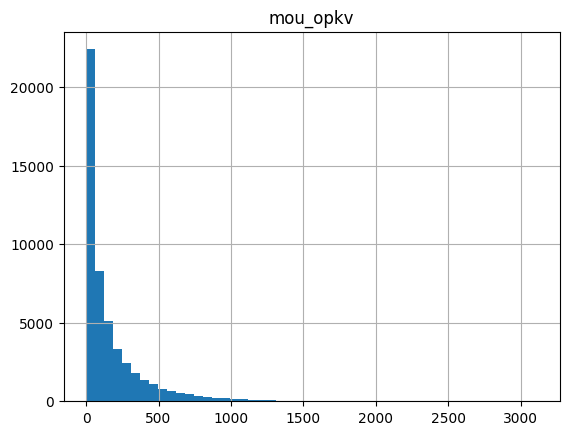

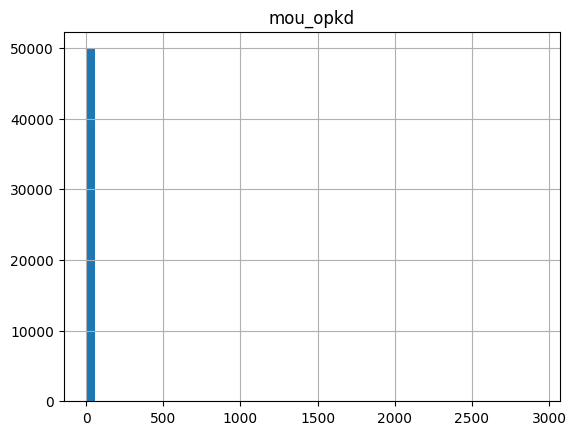

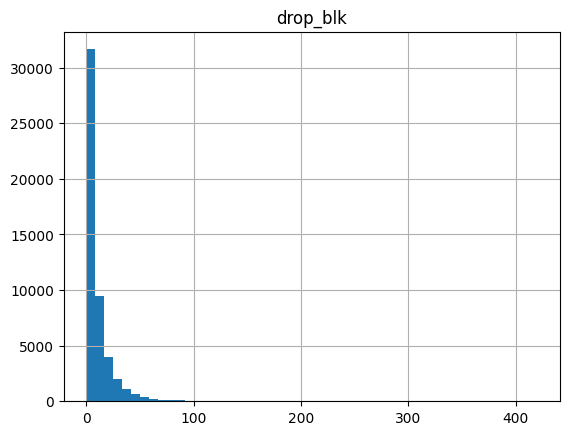

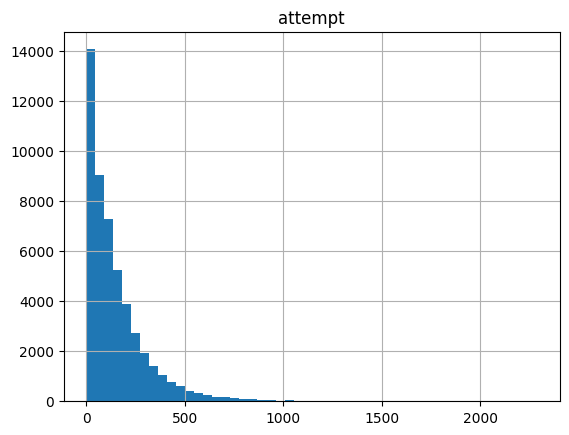

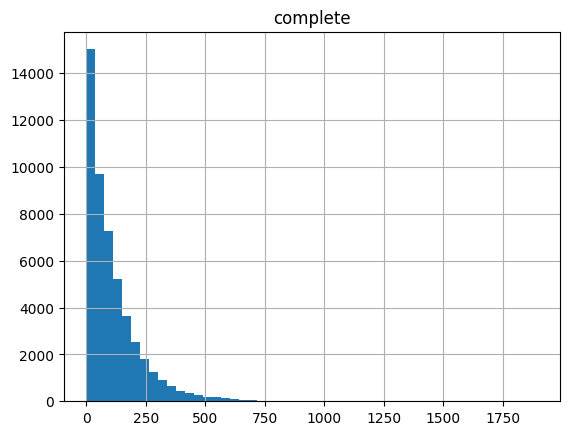

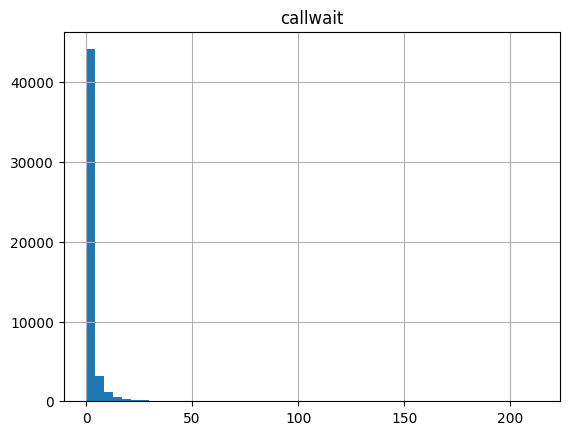

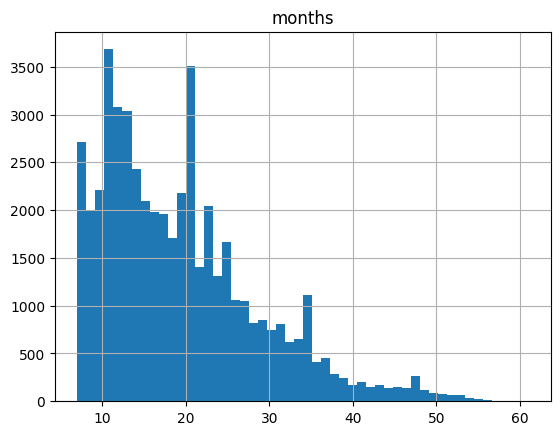

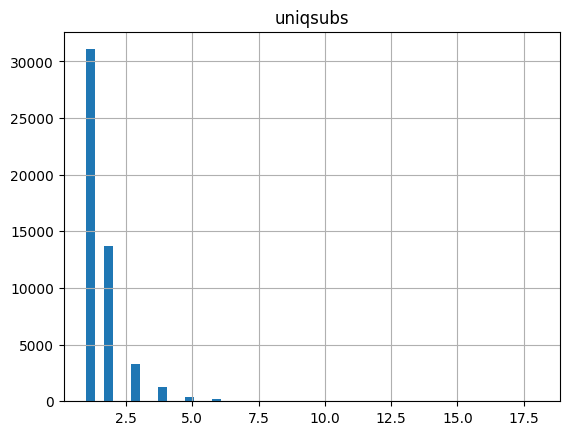

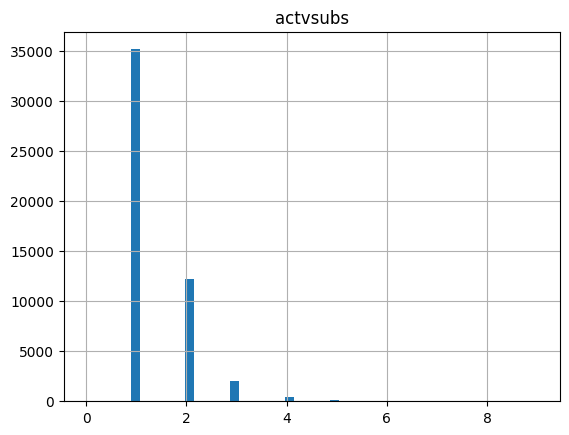

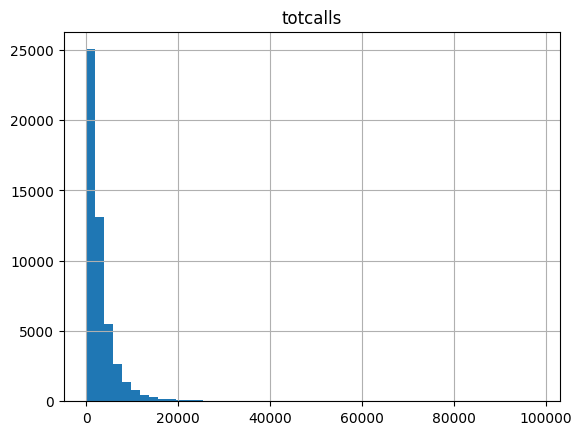

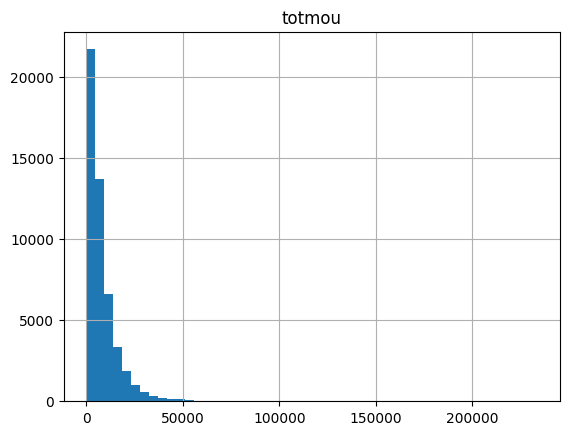

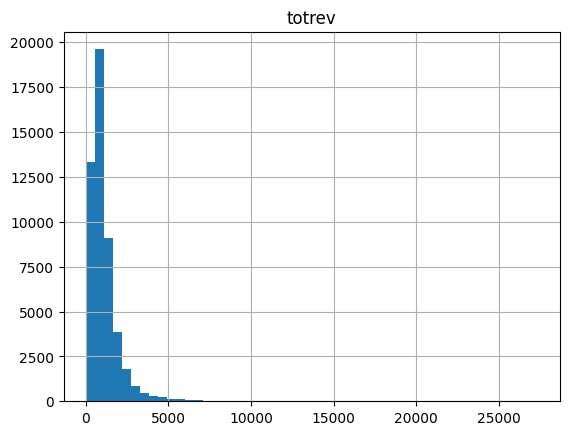

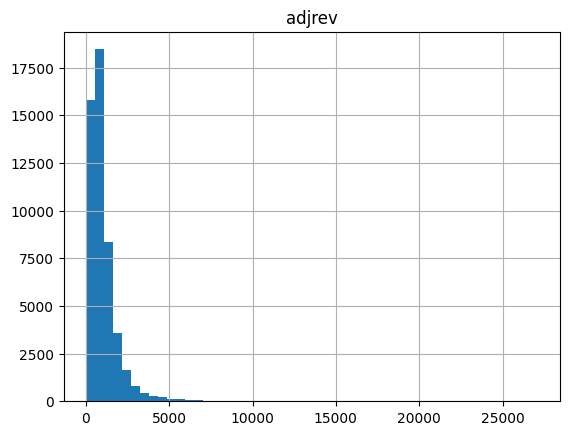

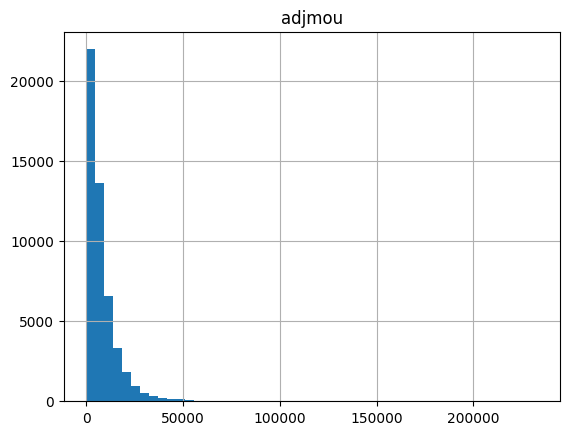

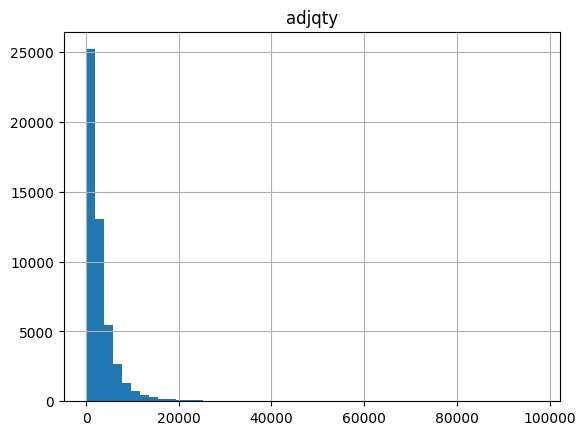

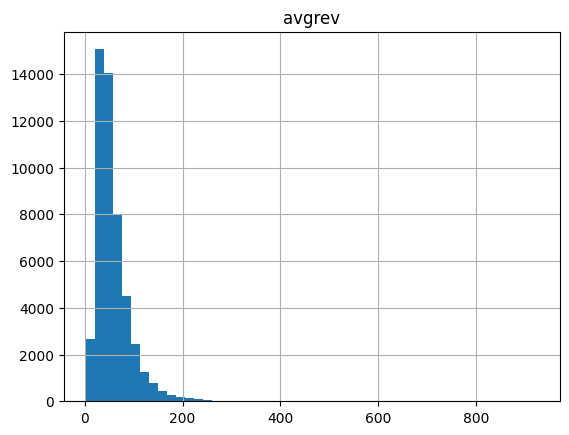

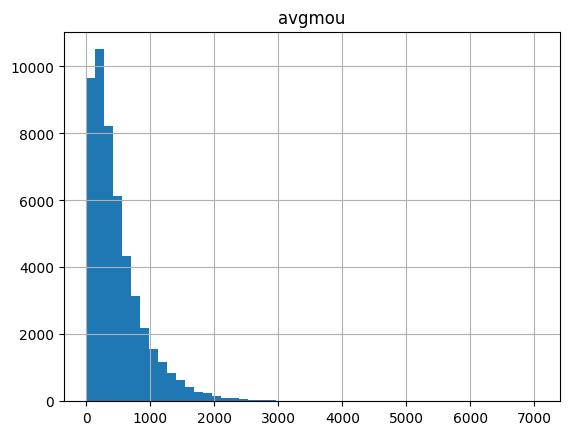

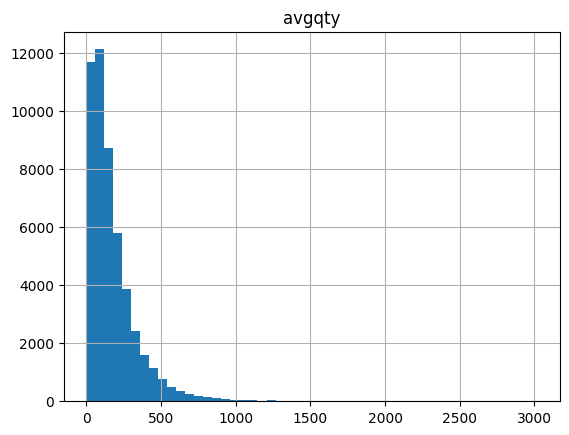

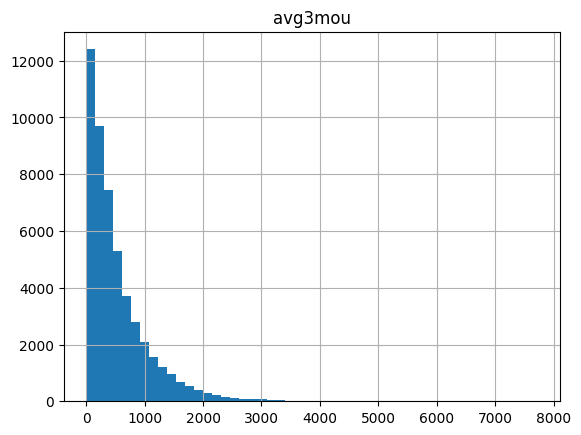

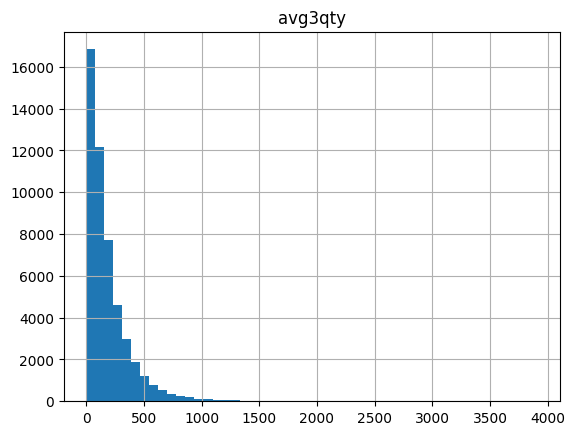

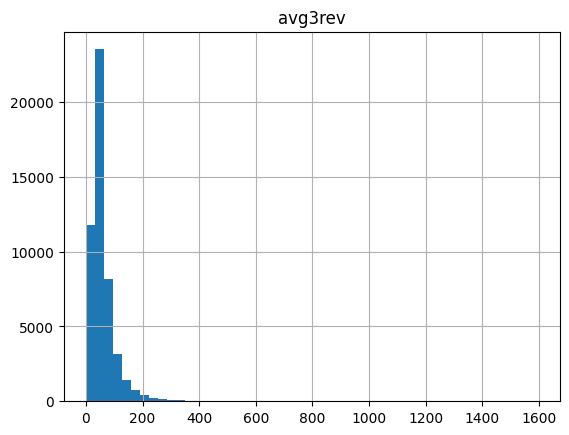

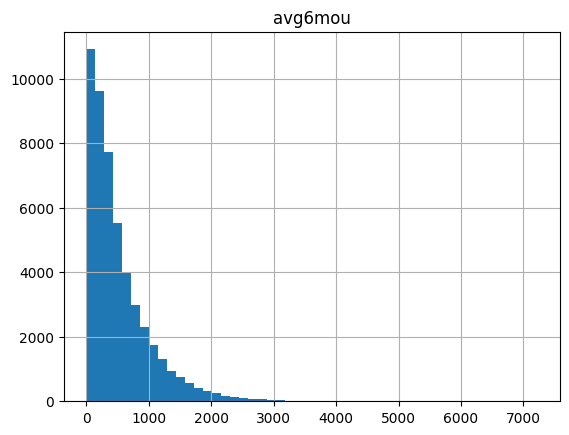

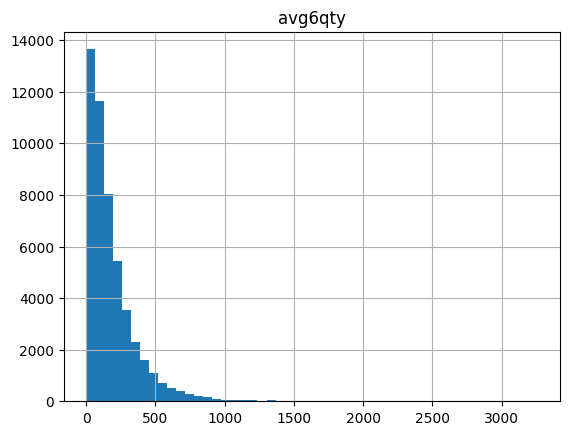

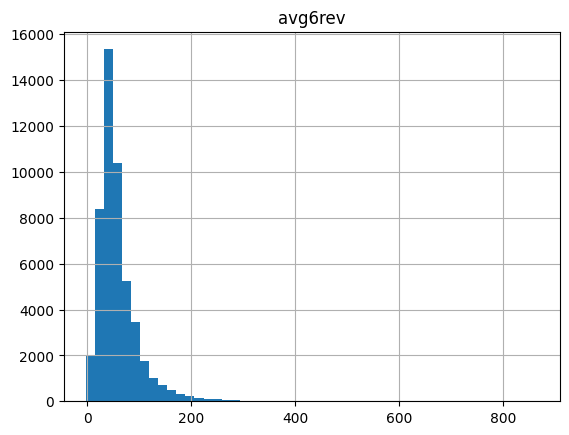

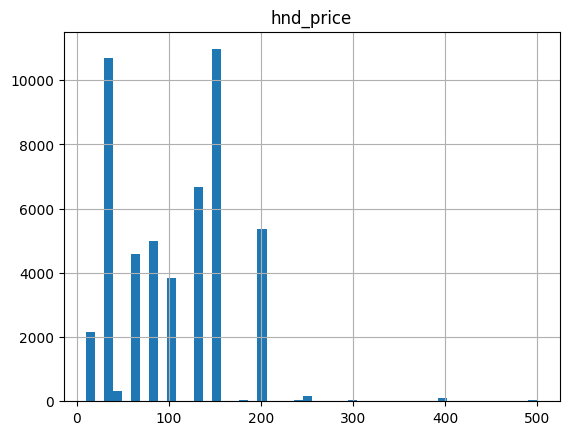

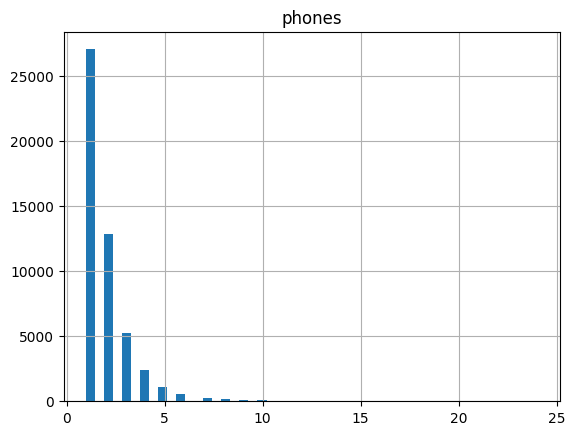

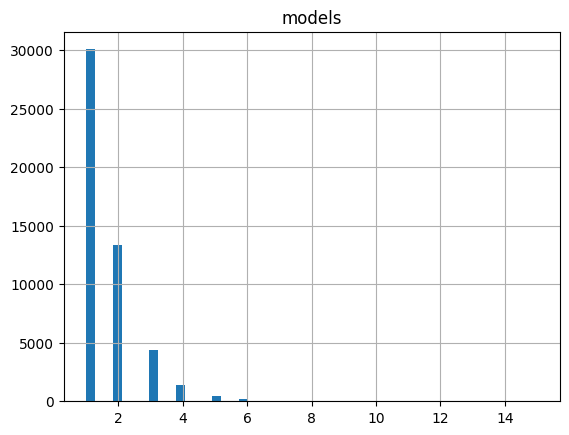

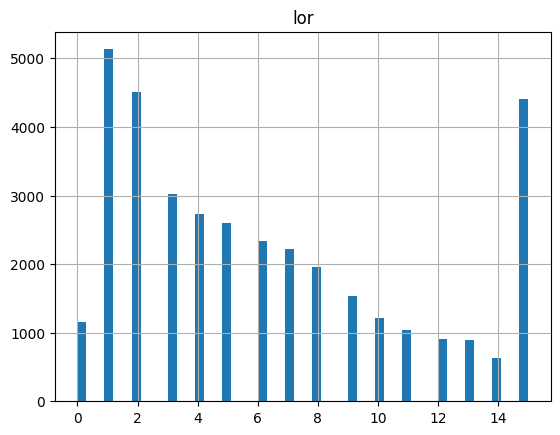

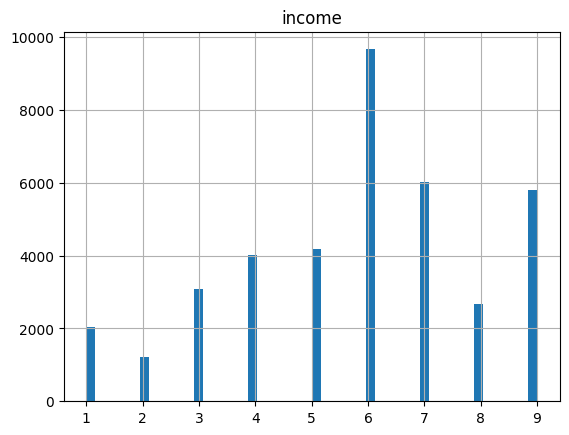

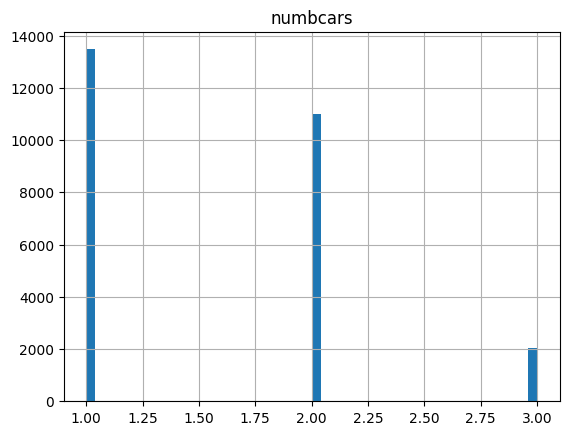

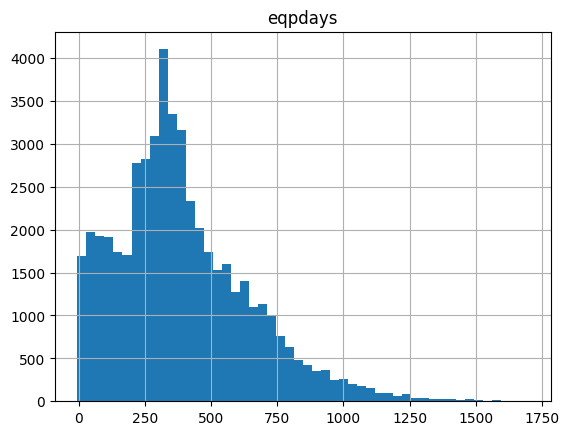

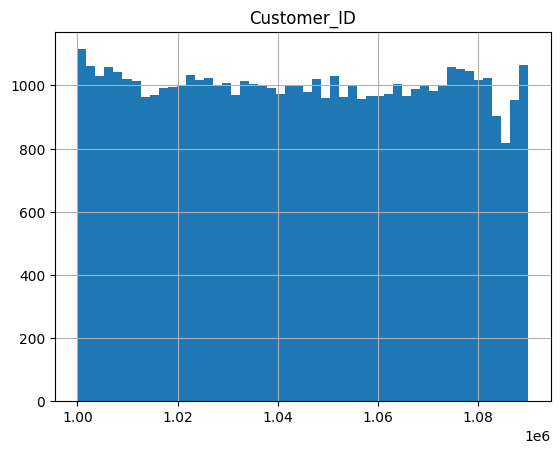

In [12]:
for col in lista_numericas:
    df.hist(col, bins=50)

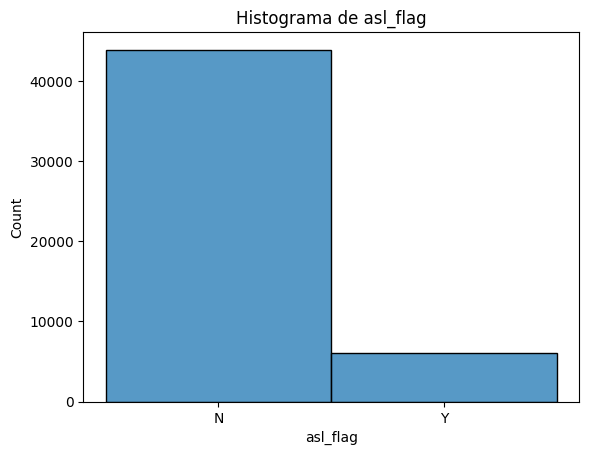

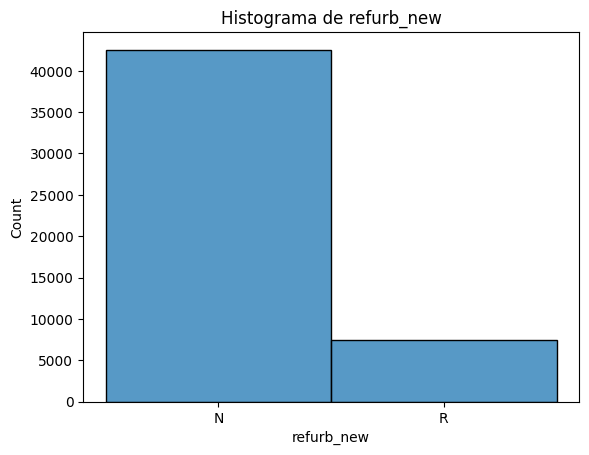

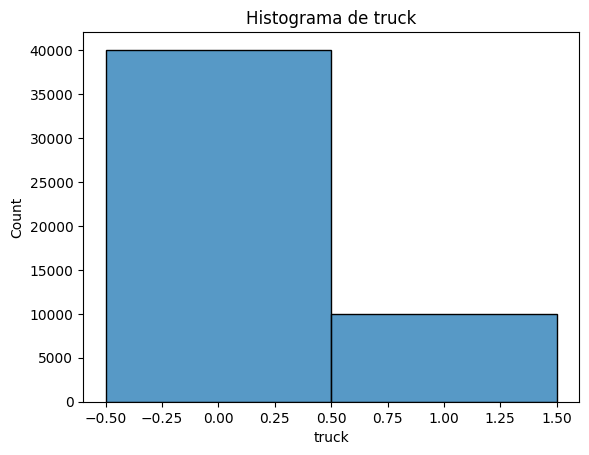

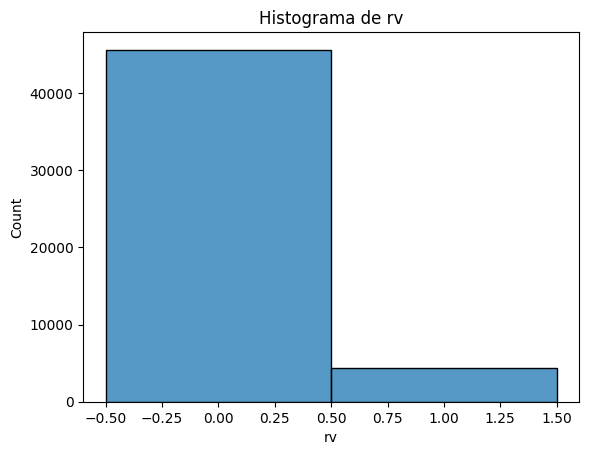

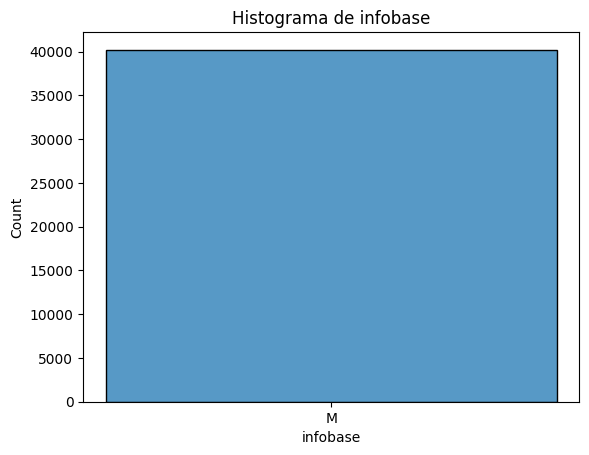

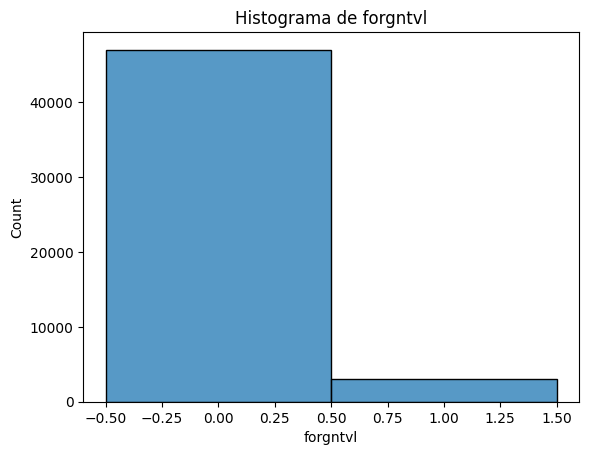

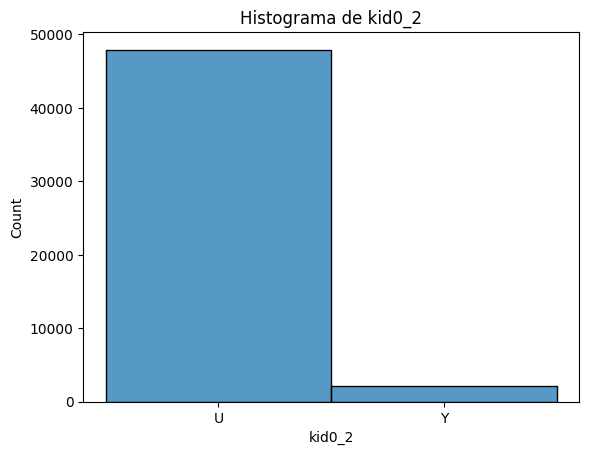

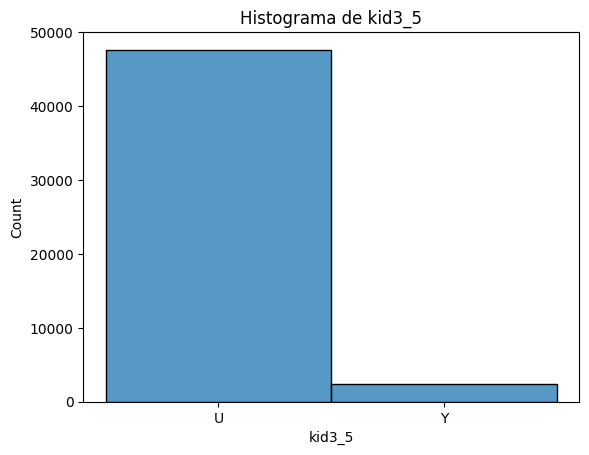

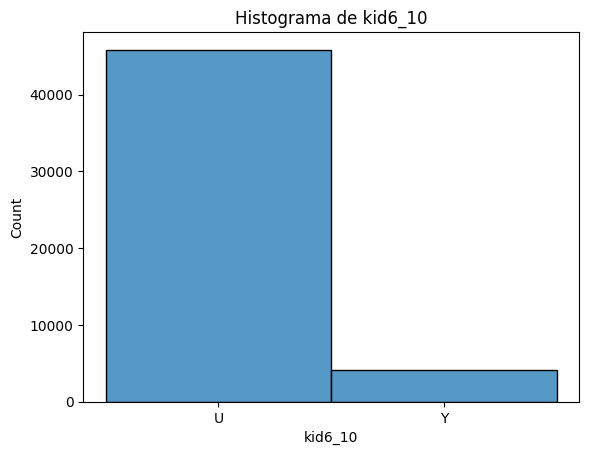

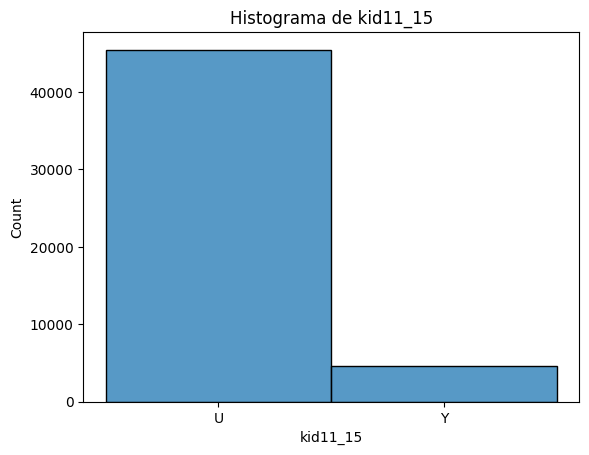

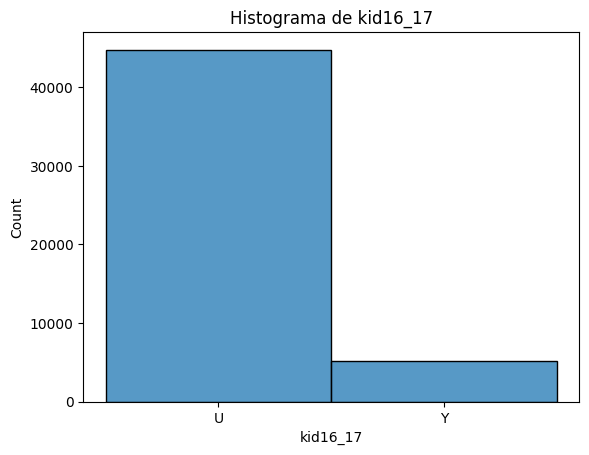

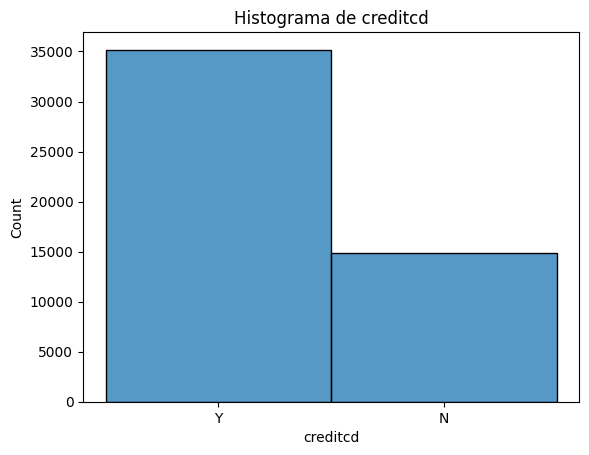

In [13]:
for col in lista_boolean:
    sns.histplot(data=df, x=col, discrete=True)
    plt.title(f'Histograma de {col}')
    plt.show()

In [14]:
# borramos infobase
df.drop(columns='infobase', inplace=True)
df_pred.drop(columns='infobase', inplace=True)

In [15]:
# comprobamos que los Customer_ID no coinciden
df_customer_id = df['Customer_ID'].to_list()
df_pred_customer_id = df_pred['Customer_ID'].to_list()

coincide = [x for x in df_customer_id if x in df_pred_customer_id]
coincide

[]

In [16]:
# borramos Customer_ID
df.drop(columns='Customer_ID', inplace=True)
df_pred.drop(columns='Customer_ID', inplace=True)

In [17]:
for col in lista_categoricas:
    print(df[col].value_counts(normalize=True, dropna=False))
    print()

crclscod
AA    0.37336
A     0.17520
BA    0.12324
CA    0.08302
EA    0.06634
B     0.04226
DA    0.03710
ZA    0.03682
C     0.01692
A2    0.00814
U     0.00508
E     0.00404
E4    0.00324
D     0.00302
GA    0.00296
G     0.00258
Z     0.00214
JF    0.00206
M     0.00176
C2    0.00138
W     0.00114
I     0.00114
D4    0.00110
Z4    0.00086
U1    0.00064
V1    0.00058
EM    0.00054
EC    0.00042
B2    0.00036
E2    0.00028
O     0.00028
CY    0.00022
J     0.00020
D5    0.00018
CC    0.00018
Y     0.00018
K     0.00016
C5    0.00016
Z5    0.00012
Z1    0.00012
ZY    0.00010
Z2    0.00008
A3    0.00004
D2    0.00004
TP    0.00004
H     0.00004
EF    0.00004
IF    0.00004
P1    0.00002
GY    0.00002
ZF    0.00002
Name: proportion, dtype: float64

prizm_social_one
S      0.32724
U      0.23784
C      0.17016
T      0.15136
NaN    0.06584
R      0.04756
Name: proportion, dtype: float64

area
NEW YORK CITY AREA               0.11540
DC/MARYLAND/VIRGINIA AREA        0.06676
MIDWEST AREA   

### Columnas candidatas para ser borradas por escasa varianza: blck_dat, roam, comp_dat, peak_dat, opk_dat, mou_opkd
### Columnas numericas que podrian ser tratadas como categoricas: uniqsubs, actvsubs, phones, models, lor, income, numbcars, 

### Analisis variables-target

In [18]:
# graficos_por_fila = 4
# variables = list(df.columns)
# variables.remove(target)
# num_variables =len(variables)

# fig, axs = plt.subplots(ncols=graficos_por_fila, nrows=(num_variables + graficos_por_fila - 1) // graficos_por_fila, figsize=(15,60))
# axs = axs.flatten()

# for i, var in enumerate(variables):
#     sns.scatterplot(data=df, x=var, y=target, ax=axs[i], hue=target)
#     axs[i].set_title(f'{var} vs {target}')
#     axs[i].set_xlabel(var)
#     axs[i].set_ylabel(target)

# plt.tight_layout()

# Preprocessing

## Data Cleaning

### Duplicados

In [19]:
df[df.duplicated()]

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,numbcars,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays


## Tratamiento de nulos

In [20]:
# df_nulos
df_nulls = df.isna().sum().reset_index(name='nulls')
df_nulls[df_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls
61,area,720
60,prizm_social_one,3292
67,hnd_webcap,4971
73,income,11312
71,lor,13713
70,ownrent,15446
74,numbcars,23481


In [21]:
# df_pred nulos
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls
6,roam,25
61,dualband,25
59,prizm_social_one,88
66,hnd_webcap,155
72,income,305
70,lor,390
69,ownrent,427
73,numbcars,676


### area

In [22]:
df['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.540
DC/MARYLAND/VIRGINIA AREA         6.676
MIDWEST AREA                      6.578
ATLANTIC SOUTH AREA               6.058
CALIFORNIA NORTH AREA             5.910
DALLAS AREA                       5.688
NEW ENGLAND AREA                  5.340
SOUTHWEST AREA                    5.266
CHICAGO AREA                      5.156
LOS ANGELES AREA                  4.860
GREAT LAKES AREA                  4.842
OHIO AREA                         4.840
HOUSTON AREA                      4.290
CENTRAL/SOUTH TEXAS AREA          4.278
NORTH FLORIDA AREA                4.250
NORTHWEST/ROCKY MOUNTAIN AREA     4.226
SOUTH FLORIDA AREA                3.362
TENNESSEE AREA                    2.886
PHILADELPHIA AREA                 2.514
NaN                               1.440
Name: proportion, dtype: float64

##### No tenemos manera de saber el area. Imputamos 'Unknown'

In [23]:
# Imputamos 'Unknown'
df['area'].fillna('Unknown', inplace=True)

df['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.540
DC/MARYLAND/VIRGINIA AREA         6.676
MIDWEST AREA                      6.578
ATLANTIC SOUTH AREA               6.058
CALIFORNIA NORTH AREA             5.910
DALLAS AREA                       5.688
NEW ENGLAND AREA                  5.340
SOUTHWEST AREA                    5.266
CHICAGO AREA                      5.156
LOS ANGELES AREA                  4.860
GREAT LAKES AREA                  4.842
OHIO AREA                         4.840
HOUSTON AREA                      4.290
CENTRAL/SOUTH TEXAS AREA          4.278
NORTH FLORIDA AREA                4.250
NORTHWEST/ROCKY MOUNTAIN AREA     4.226
SOUTH FLORIDA AREA                3.362
TENNESSEE AREA                    2.886
PHILADELPHIA AREA                 2.514
Unknown                           1.440
Name: proportion, dtype: float64

### prizm_social_one: "Social group letter only"
##### probablemente signifiquen 'Suburban', 'Urban', 'Country', 'Town', 'Rural'. No podemos clasificarlos ordinalmente

In [24]:
df['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S      32.724
U      23.784
C      17.016
T      15.136
NaN     6.584
R       4.756
Name: proportion, dtype: float64

In [25]:
# Imputamos 'Unknown'
df['prizm_social_one'].fillna('Unknown', inplace=True)
df_pred['prizm_social_one'].fillna('Unknown', inplace=True)

df['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S          32.724
U          23.784
C          17.016
T          15.136
Unknown     6.584
R           4.756
Name: proportion, dtype: float64

### hnd_webcap: "Handset web capability"
##### Capacidad del dispositivo para acceder a la web. Podemos clasificar los nulos como 'Unknown'

In [26]:
df['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB    77.102
WC      12.956
NaN      9.942
Name: proportion, dtype: float64

In [27]:
# Imputamos 'Unknown'
df['hnd_webcap'].fillna('Unknown', inplace=True)
df_pred['hnd_webcap'].fillna('Unknown', inplace=True)

df['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB       77.102
WC         12.956
Unknown     9.942
Name: proportion, dtype: float64

### income: "Estimated income"

In [28]:
df['income'].value_counts(dropna=False, normalize=True)*100

income
NaN    22.624
6.0    19.332
7.0    12.068
9.0    11.616
5.0     8.350
4.0     8.024
3.0     6.144
8.0     5.368
1.0     4.052
2.0     2.422
Name: proportion, dtype: float64

##### Los numeros de income (1-9) representan grupos de ingresos. Vamos a ver cuanto gasta al mes grupo uno de media:

In [29]:
df.groupby('income', dropna=False)['rev'].mean().sort_index()


income
1.0    64.935487
2.0    61.346250
3.0    60.015719
4.0    57.659438
5.0    58.232545
6.0    55.903128
7.0    56.490268
8.0    58.322053
9.0    56.496586
NaN    66.218505
Name: rev, dtype: float64

##### Siguen un orden lineal de gasto. Asumiremos que los NaN tienen income = 0.0

In [30]:
# Imputamos 0.0
df['income'].fillna(0.0, inplace=True)
df_pred['income'].fillna(0.0, inplace=True)

df['income'].value_counts(dropna=False, normalize=True)*100

income
0.0    22.624
6.0    19.332
7.0    12.068
9.0    11.616
5.0     8.350
4.0     8.024
3.0     6.144
8.0     5.368
1.0     4.052
2.0     2.422
Name: proportion, dtype: float64

### lor: "Length of residence"
##### Representa el tiempo que lleva el cliente viviendo en su domicilio actual

In [31]:
df['lor'].value_counts(dropna=False, normalize=True)*100

lor
NaN     27.426
1.0     10.264
2.0      9.030
15.0     8.810
3.0      6.048
4.0      5.462
5.0      5.212
6.0      4.662
7.0      4.444
8.0      3.904
9.0      3.072
10.0     2.438
0.0      2.298
11.0     2.070
12.0     1.812
13.0     1.798
14.0     1.250
Name: proportion, dtype: float64

##### No tenemos ni idea de que puede ser NaN, asi que imputaremos Unknown
##### Para evitar generar demasiadas columnas con el OneHotEncoder, dividiremos los valores en categorias

<Axes: xlabel='lor', ylabel='churn'>

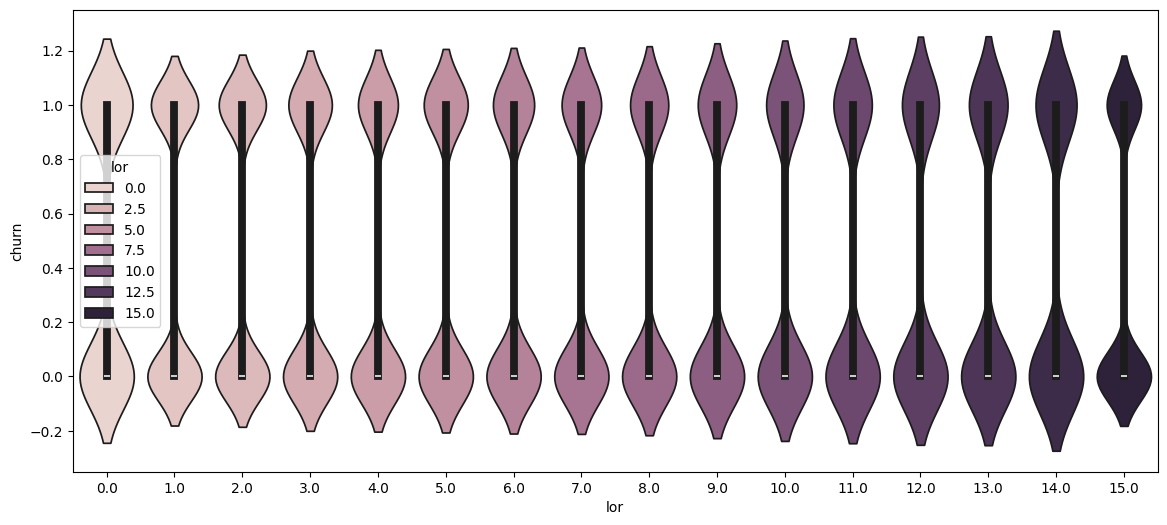

In [32]:
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x='lor', y=target, hue='lor')

In [33]:
# 0-3, 4-6, 7-9, 10-12, 13-15, Unknown
def lor_cat(year):
    if pd.isna(year):
        return 'Unknown'
    if year >= 0.0 and year <=3.0:
        return '0-3'
    if year >= 4.0 and year <=6.0:
        return '4-6'
    if year >= 7.0 and year <=9.0:
        return '7-9'
    if year >= 10.0 and year <=12.0:
        return '10-12'
    if year >= 13.0:
        return '13-15'
    return 'Other'

In [34]:
# nos guardamos el valor original de df['lor']
lor_original = df['lor']

# aplicamos la funcion a df y df_pred
df['lor'] = df['lor'].apply(lambda x: lor_cat(x))
df_pred['lor'] = df_pred['lor'].apply(lambda x: lor_cat(x))

# comprobamos que ha funcionado como esperabamos
df[['lor']].merge(lor_original, left_index=True, right_index=True)

,lor_x,lor_y
0,13-15,15.0
1,4-6,5.0
2,0-3,1.0
3,7-9,8.0
4,0-3,0.0
...,...,...
49995,0-3,1.0
49996,0-3,2.0
49997,0-3,1.0
49998,0-3,3.0


In [35]:
df['lor'].value_counts(normalize=True)*100

lor
0-3        27.640
Unknown    27.426
4-6        15.336
13-15      11.858
7-9        11.420
10-12       6.320
Name: proportion, dtype: float64

<Axes: xlabel='lor', ylabel='churn'>

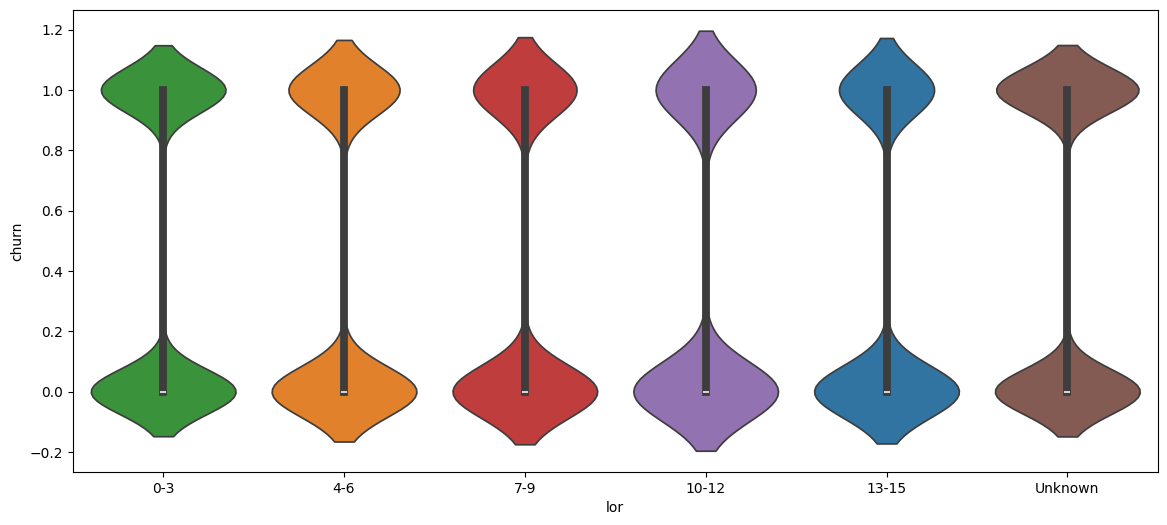

In [36]:
order = ['0-3', '4-6', '7-9', '10-12', '13-15', 'Unknown']
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x='lor', y=target, hue='lor', order=order)

### ownrent: "Home owner/renter status"
##### Representa si el cliente tiene una casa en propiedad o vive de alquiler

In [37]:
df['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O      67.118
NaN    30.892
R       1.990
Name: proportion, dtype: float64

In [38]:
# Imputamos 'Unknown'
df['ownrent'].fillna('Unknown', inplace=True)
df_pred['ownrent'].fillna('Unknown', inplace=True)

df['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O          67.118
Unknown    30.892
R           1.990
Name: proportion, dtype: float64

### numbcars: "Known number of vehicles"

In [39]:
df['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
NaN    46.962
1.0    26.950
2.0    22.012
3.0     4.076
Name: proportion, dtype: float64

##### Asumimos que los NaN no tienen coche

In [40]:
# Imputamos 0.0
df['numbcars'].fillna(0.0, inplace=True)
df_pred['numbcars'].fillna(0.0, inplace=True)

df['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
0.0    46.962
1.0    26.950
2.0    22.012
3.0     4.076
Name: proportion, dtype: float64

##### df_nulls restantes

In [41]:
df_nulls = df.isna().sum().reset_index(name='nulls')
df_nulls[df_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls


##### df_pred_nulls restantes


In [42]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls
6,roam,25
61,dualband,25


### roam: "Mean number of roaming calls"

In [43]:
df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     65.400000
0.0975      3.466667
NaN         1.666667
0.1600      1.466667
0.1950      1.266667
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 309, dtype: float64

In [44]:
# Imputamos la mediana
df_pred['roam'].fillna(df_pred['roam'].median(), inplace=True)

df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     67.066667
0.0975      3.466667
0.1600      1.466667
0.1950      1.266667
0.3200      0.733333
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 308, dtype: float64

### dualband

In [45]:
df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y      73.400000
N      21.933333
T       3.000000
NaN     1.666667
Name: proportion, dtype: float64

In [46]:
# Imputamos la moda
df_pred['dualband'].fillna(df_pred['dualband'].mode()[0], inplace=True)

df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y    75.066667
N    21.933333
T     3.000000
Name: proportion, dtype: float64

In [47]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

,index,nulls


## Tratamiento de variables categóricas

In [48]:
df.select_dtypes(include='object').columns

Index(['crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband',
       'refurb_new', 'hnd_webcap', 'ownrent', 'lor', 'marital', 'ethnic',
       'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

### crclscod: "Credit class code"

In [49]:
df_crclscod = df['crclscod'].value_counts(normalize=True).reset_index()
df_crclscod['cumsum'] = df_crclscod['proportion'].cumsum()
df_crclscod

,crclscod,proportion,cumsum
0,AA,0.37336,0.37336
1,A,0.17520,0.54856
2,BA,0.12324,0.67180
3,CA,0.08302,0.75482
4,EA,0.06634,0.82116
5,B,0.04226,0.86342
6,DA,0.03710,0.90052
7,ZA,0.03682,0.93734
8,C,0.01692,0.95426
9,A2,0.00814,0.96240


In [50]:
top_90_crclscod = df_crclscod[df_crclscod['cumsum']<0.9]
top_90_crclscod = top_90_crclscod['crclscod'].to_list()

In [51]:
df['crclscod'] = df['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')
df_pred['crclscod'] = df_pred['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')

df['crclscod'].value_counts(normalize=True, ascending=False)

crclscod
AA       0.37336
A        0.17520
other    0.13658
BA       0.12324
CA       0.08302
EA       0.06634
B        0.04226
Name: proportion, dtype: float64

### area

In [52]:
df['area'].value_counts(normalize=True)*100

area
NEW YORK CITY AREA               11.540
DC/MARYLAND/VIRGINIA AREA         6.676
MIDWEST AREA                      6.578
ATLANTIC SOUTH AREA               6.058
CALIFORNIA NORTH AREA             5.910
DALLAS AREA                       5.688
NEW ENGLAND AREA                  5.340
SOUTHWEST AREA                    5.266
CHICAGO AREA                      5.156
LOS ANGELES AREA                  4.860
GREAT LAKES AREA                  4.842
OHIO AREA                         4.840
HOUSTON AREA                      4.290
CENTRAL/SOUTH TEXAS AREA          4.278
NORTH FLORIDA AREA                4.250
NORTHWEST/ROCKY MOUNTAIN AREA     4.226
SOUTH FLORIDA AREA                3.362
TENNESSEE AREA                    2.886
PHILADELPHIA AREA                 2.514
Unknown                           1.440
Name: proportion, dtype: float64

In [53]:
# area va a introducir mucho ruido en el modelo (demasiadas columnas). La borramos
df.drop(columns='area', inplace=True)
df_pred.drop(columns='area', inplace=True)

### ethnic

In [54]:
df['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.34396
H    0.47940
S    0.61040
U    0.72084
G    0.78136
Z    0.83152
O    0.87266
I    0.91230
J    0.94226
F    0.96380
B    0.97806
R    0.98864
D    0.99736
M    0.99876
P    0.99996
X    1.00000
Name: proportion, dtype: float64

In [55]:
df_pred['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.374000
S    0.498667
H    0.618667
U    0.728667
G    0.791333
Z    0.841333
O    0.884667
I    0.915333
F    0.938000
J    0.960000
R    0.978000
B    0.991333
D    0.998000
M    0.999333
P    1.000000
Name: proportion, dtype: float64

In [56]:
df_ethnic = df['ethnic'].value_counts(normalize=True).reset_index()
df_ethnic['cumsum'] = df_ethnic['proportion'].cumsum()
df_ethnic

,ethnic,proportion,cumsum
0,N,0.34396,0.34396
1,H,0.13544,0.47940
2,S,0.13100,0.61040
3,U,0.11044,0.72084
4,G,0.06052,0.78136
5,Z,0.05016,0.83152
6,O,0.04114,0.87266
7,I,0.03964,0.91230
8,J,0.02996,0.94226
9,F,0.02154,0.96380


In [57]:
ethnic_top90 = df_ethnic[df_ethnic['cumsum']<0.9]
ethnic_top90 = ethnic_top90['ethnic'].to_list()
ethnic_top90

['N', 'H', 'S', 'U', 'G', 'Z', 'O']

In [58]:
df['ethnic'] = df['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')
df_pred['ethnic'] = df_pred['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')

df['ethnic'].value_counts(normalize=True)

ethnic
N        0.34396
H        0.13544
S        0.13100
other    0.12734
U        0.11044
G        0.06052
Z        0.05016
O        0.04114
Name: proportion, dtype: float64

In [59]:
df_pred['ethnic'].value_counts(normalize=True)

ethnic
N        0.374000
S        0.124667
H        0.120000
other    0.115333
U        0.110000
G        0.062667
Z        0.050000
O        0.043333
Name: proportion, dtype: float64

### variables categoricas booleanas

In [60]:
# asl_flag
df['asl_flag'] = df['asl_flag'].apply(lambda x: 0 if x=='N' else 1)
df_pred['asl_flag'] = df_pred['asl_flag'].apply(lambda x: 0 if x=='N' else 1)

df['asl_flag'].value_counts(normalize=True)

asl_flag
0    0.8778
1    0.1222
Name: proportion, dtype: float64

In [61]:
# refurb_new
df['refurb_new'] = df['refurb_new'].apply(lambda x: 0 if x=='N' else 1)
df_pred['refurb_new'] = df_pred['refurb_new'].apply(lambda x: 0 if x=='N' else 1)

df['refurb_new'].value_counts()

refurb_new
0    42561
1     7439
Name: count, dtype: int64

In [62]:
# kid0_2
df['kid0_2'] = df['kid0_2'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid0_2'] = df_pred['kid0_2'].apply(lambda x: 0 if x=='U' else 1)

df['kid0_2'].value_counts()

kid0_2
0    47942
1     2058
Name: count, dtype: int64

In [63]:
# kid3_5
df['kid3_5'] = df['kid3_5'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid3_5'] = df_pred['kid3_5'].apply(lambda x: 0 if x=='U' else 1)

df['kid3_5'].value_counts()

kid3_5
0    47648
1     2352
Name: count, dtype: int64

In [64]:
# kid6_10
df['kid6_10'] = df['kid6_10'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid6_10'] = df_pred['kid6_10'].apply(lambda x: 0 if x=='U' else 1)

df['kid6_10'].value_counts()

kid6_10
0    45861
1     4139
Name: count, dtype: int64

In [65]:
# kid11_15
df['kid11_15'] = df['kid11_15'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid11_15'] = df_pred['kid11_15'].apply(lambda x: 0 if x=='U' else 1)

df['kid11_15'].value_counts()

kid11_15
0    45459
1     4541
Name: count, dtype: int64

In [66]:
# kid16_17
df['kid16_17'] = df['kid16_17'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid16_17'] = df_pred['kid16_17'].apply(lambda x: 0 if x=='U' else 1)

df['kid16_17'].value_counts()

kid16_17
0    44802
1     5198
Name: count, dtype: int64

In [67]:
# creditcd
df['creditcd'] = df['creditcd'].apply(lambda x: 0 if x=='N' else 1)
df_pred['creditcd'] = df_pred['creditcd'].apply(lambda x: 0 if x=='N' else 1)

df['creditcd'].value_counts()

creditcd
1    35177
0    14823
Name: count, dtype: int64

### one hot encoding

In [68]:
cols_categoricas = df.select_dtypes(include='object').columns.to_list()
cols_categoricas

['crclscod',
 'prizm_social_one',
 'dualband',
 'hnd_webcap',
 'ownrent',
 'lor',
 'marital',
 'ethnic']

In [69]:
encoder = OneHotEncoder(sparse_output=False)

data_encoded = encoder.fit_transform(df[cols_categoricas])
df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out())
df.drop(columns=cols_categoricas, inplace=True)
df = df.merge(df_encoded, left_index=True, right_index=True)
df

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
0,23.9975,219.25,22.50,0.00,0.0000,0.0,0.0000,-157.25,-18.9975,0.666667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,55.2300,570.50,71.98,0.00,0.0000,0.0,0.0000,38.50,0.0000,9.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,82.2750,1312.25,75.00,0.00,0.0000,0.0,0.0000,156.75,8.1450,52.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,17.1450,0.00,16.99,0.00,0.0000,0.0,0.0000,0.00,-0.1550,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,38.0525,682.50,52.49,0.00,0.0000,0.0,0.0000,147.50,-3.0625,9.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,29.2650,61.00,29.99,17.25,6.9000,6.9,0.6875,-37.00,-9.2750,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49996,80.9950,882.00,50.11,49.50,19.7325,17.1,10.4100,75.00,-26.7350,12.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49997,21.9475,140.00,10.00,29.25,11.7000,11.7,0.0000,123.00,-4.9575,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49998,125.2700,936.25,79.99,131.75,52.7000,52.7,2.5800,109.75,-22.5000,11.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
# aplicamos las transformaciones al df_pred
data_pred_encoded = encoder.transform(df_pred[cols_categoricas])
df_pred_encoded = pd.DataFrame(data_pred_encoded, columns=encoder.get_feature_names_out())
df_pred.drop(columns=cols_categoricas, inplace=True)
df_pred = df_pred.merge(df_pred_encoded, left_index=True, right_index=True)
df_pred


,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
0,31.4475,56.00,30.0000,8.75,1.4475,1.4475,0.0000,-34.00,-1.4475,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76.7375,1007.75,59.9900,65.25,19.5750,19.5750,6.6775,-51.75,5.3625,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,159.0400,2542.50,75.0000,458.25,45.8250,45.8250,9.5600,-225.50,-19.3600,34.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,67.2750,602.50,50.0000,73.25,7.3250,7.3250,4.8000,-155.50,-12.8250,21.666667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,80.2825,1245.25,68.2950,73.00,18.2500,18.2500,0.0000,-160.25,-62.0725,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,58.3250,507.00,44.9900,55.00,22.0000,22.0000,0.0975,172.00,48.2550,8.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1496,65.3575,320.00,79.9900,0.00,0.0000,0.0000,3.8825,-38.00,0.5925,5.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1497,76.8425,561.25,80.7425,0.00,0.2000,0.0000,0.0000,-35.25,111.1375,10.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1498,78.6650,984.50,69.9900,55.50,22.2000,22.2000,0.0000,-120.50,8.4850,18.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Alta correlación

In [71]:
df_corr = df.corr(numeric_only=True)
df_corr.style.background_gradient(cmap='coolwarm')

In [72]:
# nos quedamos con el triangulo superior
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df.columns)
df_triangulo.index=df.columns
df_triangulo

,rev,mou,totmrc,ovrmou,ovrrev,vceovr,roam,change_mou,change_rev,drop_vce,...,marital_S,marital_U,ethnic_G,ethnic_H,ethnic_N,ethnic_O,ethnic_S,ethnic_U,ethnic_Z,ethnic_other
rev,0.0,0.707372,0.590892,0.756031,0.758692,0.754377,0.439502,0.128565,0.220020,0.420365,...,0.015545,0.069849,-0.011296,0.036120,-0.020171,-0.039332,0.001012,-0.008632,0.049961,-0.002442
mou,0.0,0.000000,0.585287,0.580035,0.540117,0.539081,0.147204,0.007504,0.037254,0.598091,...,0.025946,0.112257,-0.030563,0.062948,-0.050975,-0.005236,-0.017677,-0.008434,0.082387,0.004880
totmrc,0.0,0.000000,0.000000,0.214775,0.173347,0.171796,0.040145,-0.018669,-0.023147,0.354627,...,0.006938,0.075249,-0.005990,0.021533,-0.008533,-0.028706,-0.004377,-0.002242,0.029927,-0.001615
ovrmou,0.0,0.000000,0.000000,0.000000,0.952835,0.949790,0.039389,-0.028169,-0.028640,0.350572,...,0.009598,0.047601,-0.010723,0.025547,-0.019937,-0.025265,0.008473,-0.012927,0.047723,-0.002760
ovrrev,0.0,0.000000,0.000000,0.000000,0.000000,0.994986,0.036705,-0.017669,-0.011168,0.333149,...,0.013097,0.053306,-0.013361,0.028543,-0.020505,-0.024814,0.005910,-0.012269,0.049547,-0.002626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethnic_O,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080423,-0.072984,-0.047600,-0.079125
ethnic_S,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.136805,-0.089224,-0.148315
ethnic_U,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080971,-0.134597
ethnic_Z,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.087784


In [73]:
# correlaciones superiores a 0.9
cols = ['variable1','variable2','correlacion']
df_stack = df_triangulo.stack().reset_index()
df_stack.columns=cols

df_altas_correlaciones = df_stack[df_stack['correlacion']>0.9]
df_altas_correlaciones

,variable1,variable2,correlacion
55,rev,avg3rev,0.916263
169,mou,avg3mou,0.981792
172,mou,avg6mou,0.946929
352,ovrmou,ovrrev,0.952835
353,ovrmou,vceovr,0.949790
469,ovrrev,vceovr,0.994986
1523,plcd_vce,comp_vce,0.985531
1544,plcd_vce,attempt,0.998374
1545,plcd_vce,complete,0.983301
1644,recv_vce,inonemin,0.965658


In [74]:
# correlaciones con el target
corr_con_target = df_corr[target]

df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
55,rev,avg3rev,0.916263,-0.042755,-0.049085
169,mou,avg3mou,0.981792,-0.136841,-0.121849
172,mou,avg6mou,0.946929,-0.136841,-0.113166
352,ovrmou,ovrrev,0.952835,0.033961,0.045001
353,ovrmou,vceovr,0.949790,0.033961,0.046113
469,ovrrev,vceovr,0.994986,0.045001,0.046113
1523,plcd_vce,comp_vce,0.985531,-0.110247,-0.117977
1544,plcd_vce,attempt,0.998374,-0.110247,-0.110687
1545,plcd_vce,complete,0.983301,-0.110247,-0.118414
1644,recv_vce,inonemin,0.965658,-0.091021,-0.073544


In [75]:
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda df: df['variable1'] if np.abs(df['corr_var1_target']) > np.abs(df['corr_var2_target']) 
                                                                                     else df['variable2'], axis=1)

In [76]:
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
55,rev,avg3rev,0.916263,-0.042755,-0.049085,avg3rev
169,mou,avg3mou,0.981792,-0.136841,-0.121849,mou
172,mou,avg6mou,0.946929,-0.136841,-0.113166,mou
352,ovrmou,ovrrev,0.952835,0.033961,0.045001,ovrrev
353,ovrmou,vceovr,0.949790,0.033961,0.046113,vceovr
469,ovrrev,vceovr,0.994986,0.045001,0.046113,vceovr
1523,plcd_vce,comp_vce,0.985531,-0.110247,-0.117977,comp_vce
1544,plcd_vce,attempt,0.998374,-0.110247,-0.110687,attempt
1545,plcd_vce,complete,0.983301,-0.110247,-0.118414,complete
1644,recv_vce,inonemin,0.965658,-0.091021,-0.073544,recv_vce


In [77]:
variables_menos_corr = df_altas_correlaciones['var_menos_corr'].to_list()

df.drop(columns=variables_menos_corr, inplace=True)
df_pred.drop(columns=variables_menos_corr, inplace=True)

print(f'Eliminamos {len(variables_menos_corr)} variables con alta correlacion de df y df_pred')
print(f'Nos quedamos con {df.shape[1]} columnas')

Eliminamos 31 variables con alta correlacion de df y df_pred
Nos quedamos con 97 columnas


## Baja varianza

In [78]:
poca_varianza = []
for col in df:
    if df[col].var()< 0.05:
        print(col, df[col].var())
        poca_varianza.append(col)
print()
print(f'{len(poca_varianza)} columnas con poca varianza')

kid0_2 0.03946664373283874
kid3_5 0.04482813496271207
crclscod_B 0.04047490189797807
prizm_social_one_R 0.045298952379070716
dualband_T 0.03996190923818319
ownrent_R 0.019504380087610677
ethnic_O 0.03944828936581301
ethnic_Z 0.04764492729855883

8 columnas con poca varianza


In [79]:
df.drop(columns=poca_varianza, inplace=True)
df_pred.drop(columns=poca_varianza, inplace=True)

print(f'Eliminamos {len(poca_varianza)}')
print(f'Nos quedamos con {df.shape[1]} columnas')

Eliminamos 8
Nos quedamos con 89 columnas


# Modelado

## Feature importance

<Axes: title={'center': 'churn feature importance - Random Forest model'}, ylabel='None'>

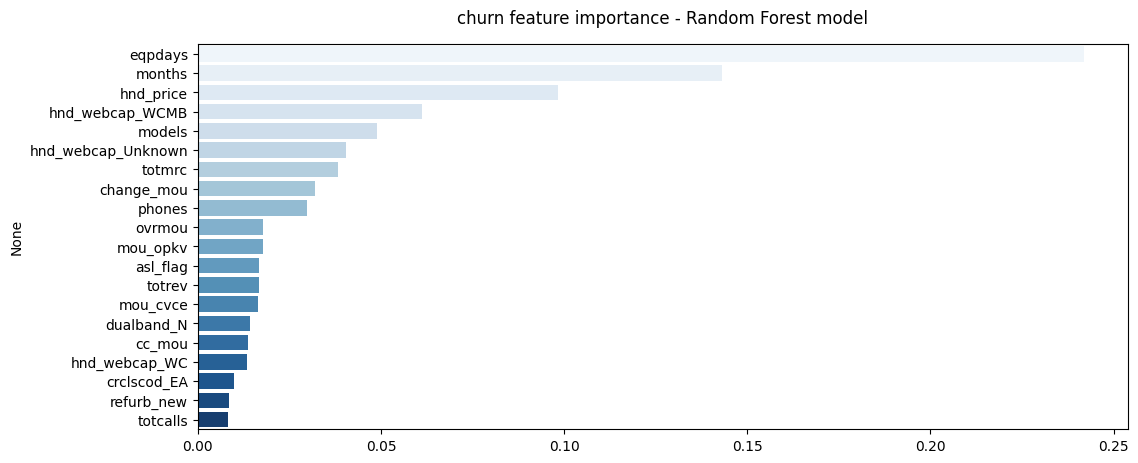

In [80]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

forest = RandomForestClassifier(**params)
x,y = df.drop(columns=target), df[target]
forest.fit(x,y)
best_features = forest.feature_importances_
columns = x.columns
imp = pd.Series(data=best_features, index=columns).sort_values(ascending=False)[:20]

plt.figure(figsize=(12,5))
plt.title(f'{target} feature importance - Random Forest model', pad=15)
sns.barplot(x=imp.values, y=imp.index, palette='Blues', orient='h')


In [81]:
print('Las 20 caracteristicas mas importantes:')
imp[:20]

Las 20 caracteristicas mas importantes:


eqpdays               0.241838
months                0.143092
hnd_price             0.098323
hnd_webcap_WCMB       0.061208
models                0.048774
hnd_webcap_Unknown    0.040344
totmrc                0.038293
change_mou            0.031917
phones                0.029874
ovrmou                0.017838
mou_opkv              0.017810
asl_flag              0.016787
totrev                0.016772
mou_cvce              0.016375
dualband_N            0.014269
cc_mou                0.013711
hnd_webcap_WC         0.013305
crclscod_EA           0.009921
refurb_new            0.008520
totcalls              0.008130
dtype: float64

## Split train-test

In [82]:
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)

## Rebalanceo del train

## Estandarización

In [83]:
df_pred.select_dtypes(include='object')

""
0
1
2
3
4
...
1495
1496
1497
1498


In [84]:
escala = StandardScaler()

X_train = escala.fit_transform(X_train)
X_test = escala.transform(X_test)
X_pred = escala.transform(df_pred)

## Competición de modelos


Competir sobre el f1_score

In [ ]:
modelos = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
    ('SVC', SVC()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False))
]

In [86]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'F1_score'])

for nombre, modelo in modelos:

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    score = f1_score(y_test, y_pred)

    metricas_modelos = pd.concat([metricas_modelos,
                                pd.DataFrame({'modelo':nombre, 'F1_score':score}, index=[0])])

metricas_modelos.sort_values(by='F1_score', ascending=False)



Learning rate set to 0.047017
0:	learn: 0.6780765	total: 67.4ms	remaining: 1m 7s
1:	learn: 0.6655092	total: 75.8ms	remaining: 37.8s
2:	learn: 0.6534845	total: 83.1ms	remaining: 27.6s
3:	learn: 0.6422965	total: 90.2ms	remaining: 22.5s
4:	learn: 0.6322980	total: 97.1ms	remaining: 19.3s
5:	learn: 0.6224068	total: 104ms	remaining: 17.3s
6:	learn: 0.6143195	total: 112ms	remaining: 15.8s
7:	learn: 0.6074391	total: 119ms	remaining: 14.8s
8:	learn: 0.6015998	total: 126ms	remaining: 13.9s
9:	learn: 0.5942345	total: 134ms	remaining: 13.2s
10:	learn: 0.5878213	total: 141ms	remaining: 12.7s
11:	learn: 0.5830914	total: 147ms	remaining: 12.1s
12:	learn: 0.5781139	total: 153ms	remaining: 11.6s
13:	learn: 0.5738793	total: 158ms	remaining: 11.2s
14:	learn: 0.5702337	total: 164ms	remaining: 10.8s
15:	learn: 0.5667108	total: 170ms	remaining: 10.4s
16:	learn: 0.5619800	total: 175ms	remaining: 10.1s
17:	learn: 0.5582343	total: 180ms	remaining: 9.82s
18:	learn: 0.5543763	total: 185ms	remaining: 9.57s
19:	le

,modelo,F1_score
0,CatBoostClassifier,0.837209
0,XGBClassifier,0.826220
0,GradientBoostingClassifier,0.787397
0,RandomForestClassifier,0.783967
0,SVC,0.716841
0,DecisionTreeClassifier,0.698986
0,LogisticRegression,0.668803
0,RidgeClassifier,0.662262


## Hiperparametrización

## Entrenamiento del modelo final

In [87]:
# entrenamiento
modelo = CatBoostClassifier()
modelo.fit(X_train, y_train)

Learning rate set to 0.047017
0:	learn: 0.6780765	total: 9.96ms	remaining: 9.95s
1:	learn: 0.6655092	total: 15.4ms	remaining: 7.68s
2:	learn: 0.6534845	total: 22.1ms	remaining: 7.34s
3:	learn: 0.6422965	total: 27.5ms	remaining: 6.85s
4:	learn: 0.6322980	total: 33.1ms	remaining: 6.58s
5:	learn: 0.6224068	total: 38.6ms	remaining: 6.4s
6:	learn: 0.6143195	total: 44ms	remaining: 6.25s
7:	learn: 0.6074391	total: 49.5ms	remaining: 6.14s
8:	learn: 0.6015998	total: 55.2ms	remaining: 6.08s
9:	learn: 0.5942345	total: 60.6ms	remaining: 6s
10:	learn: 0.5878213	total: 66.1ms	remaining: 5.94s
11:	learn: 0.5830914	total: 71.5ms	remaining: 5.88s
12:	learn: 0.5781139	total: 76.8ms	remaining: 5.83s
13:	learn: 0.5738793	total: 82.4ms	remaining: 5.8s
14:	learn: 0.5702337	total: 88.2ms	remaining: 5.79s
15:	learn: 0.5667108	total: 93.9ms	remaining: 5.77s
16:	learn: 0.5619800	total: 100ms	remaining: 5.79s
17:	learn: 0.5582343	total: 106ms	remaining: 5.77s
18:	learn: 0.5543763	total: 111ms	remaining: 5.72s
19

In [88]:
# predict
pred = modelo.predict(X_pred)

In [89]:
# predict_proba

# Evaluación del modelo final

## AUC

Calcular el AUC con el predict_proba

## matriz de confusión

## f1_score

# Guardar modelo

Guardar el modelo y lo que sea necesario para ejecutarlo (scaler)

# Interpretabilidad

## Modelo lineal

Si el mejor modelo ha sido un algoritmo basado en arbole de decisión, entrenamos el mejor modelo lineal de la competición de modelos, sin hiperparametrizar

Imprimir los coeficientes por variable + intercept

Imprimir los coeficientes de las 10 variables con mayor impacto (positivo o negativo)

## Modelo de árbol de decisión

Si el mejor modelo ha sido un modelo lineal, entrenamos el mejor modelo basado en arboles de decisión, sin hiperparametrizar

&#x26a0;&#xfe0f;
El shap necesita el nombres de las variables. Estandarizar los datos los quita

### Shap values

### Summary_plot

## Interpretabilidad top 5 variables

Explicar muy brevemente cuales son las 5 variables que más impactan en el churn, y si el impacto es positivo o negativo.

# Predicción

&#x26a0;&#xfe0f;
Realizar la predicción sobre el 100% de los clientes a predecir.  


&#x26a0;&#xfe0f;
Asegurarse de hacer la predicción en las mismas condiciones que el entrenamiento

Imprimir los 20 clientes más propensos a irse

Imprimir el len del archivo de predicción

# Exportar predicción

Exportar un archivo excel con solamente 3 columnas, llamadas 'customer_id', 'predict' y 'predict_proba', **en minúscula**